## Set Up

In [676]:
import pandas as pd
import numpy as np
from itertools import chain
import datetime as dt

import matplotlib
import matplotlib.patches as patches
from matplotlib import font_manager
from matplotlib.dates import date2num
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import Normalize
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as md
from matplotlib.patches import Rectangle
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.collections import PatchCollection
from matplotlib.colors import rgb2hex

import seaborn as sns
import geopandas as gpd
import networkx as nx
from netgraph import Graph
import pycountry
import time
import string
import warnings
warnings.filterwarnings('ignore')

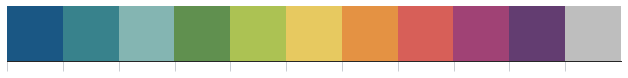

In [677]:
# Define rainbow color palette
colors = ['#1A5784', '#38828C', '#84B5B2', '#60904F', '#ACC253', '#E7C960', '#E49243', '#D75F58', '#A04275', '#633D71','#BEBEBE']
sns.palplot(sns.color_palette(colors))

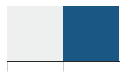

In [678]:
# Define gradient color
gradient = ['#EEEFEF','#1A5784']

cm = LinearSegmentedColormap.from_list(
        "Custom", gradient, N=100)

sns.palplot(sns.color_palette(gradient))

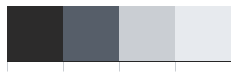

In [679]:
# Define chart color palette
chart = ['#2C2B2B','#565E69','#CACED3','#E7EAEE']
sns.palplot(sns.color_palette(chart))

In [696]:
# Define constants
figure_size = (16,9)

# # Define x-axis range
# left = dt.date(2005, 1, 1)
# right = dt.date(2023, 9, 1)

# Set background
sns.set_context('talk') #change the size from small to medium
sns.set_style('white') #change bg to white

# Add every font at the specified location
font_dir = ['/Users/haileyrobertson/Library/Fonts']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)
    
# Set font family globally
plt.rcParams['font.family'] = 'Open Sans'
plt.rcParams['font.weight'] = 'bold'

# Set margins
plt.rcParams['axes.xmargin'] = 0.2

# Define list of date formats
zfmts = ['', '%Y','%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']

# Format axes 
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.titlepad'] = 30

# Format ticks
plt.rcParams["xtick.direction"] = "out"
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.color'] = chart[2]
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['xtick.labelcolor'] = chart[1]
plt.rcParams['xtick.labelsize'] = 14

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.pad"] = -35
plt.rcParams["ytick.minor.pad"] = -35
plt.rcParams["ytick.major.size"] = 10
plt.rcParams["ytick.minor.size"] = 10
plt.rcParams["ytick.color"] = chart[2]
plt.rcParams["ytick.major.width"] = 1
plt.rcParams["ytick.minor.width"] = 1
plt.rcParams["ytick.labelcolor"] = chart[1]
plt.rcParams["ytick.labelsize"] = 14


# Adjust fontdict for title
titlefont = {'family': 'Open Sans',
             'color':  chart[0], 
             'weight': 400,
             'size': 20}

# Set grid style
plt.rcParams['grid.color'] = chart[2]
plt.rcParams['grid.linestyle'] = 'dashed'
plt.rcParams['grid.linewidth']=0.7

# Set legend style
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125

# Set axis labels
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.labelcolor'] = chart[1]

## 1. What was funded globally?
- Global capacity funding
- Core capacities
- 2016-2022

In [404]:
# Load data
raw = pd.read_csv('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/analyses/Core capacities over time (capacity funding)/results/Core capacities over time__latest.csv')

# Clean data, converting year from numeric to datetime, and dropping the calculated columns
raw['Year'] = pd.to_datetime(raw['Year'], format='%Y').dt.year
raw['Date'] = pd.to_datetime(raw['Year'].astype(str) + '-01-01')
raw = raw.drop(columns=["Total disbursed post-2013 for capacity (nominal USD)","Percentage of total distributed to this capacity in year"])

# Filter the DataFrame to only include rows in 2016-2022 range
df = raw[raw['Year'] >= 2016]
df = df[df['Year'] <= 2022]

# Show data
df.head()

,Core capacity,Core capacity code,Year,Amount disbursed for year for capacity (nominal USD),Date
12,Antimicrobial Resistance (AMR),P.3,2016,4.559669e+08,2016-01-01
13,Antimicrobial Resistance (AMR),P.3,2017,5.159066e+08,2017-01-01
14,Antimicrobial Resistance (AMR),P.3,2018,4.576564e+08,2018-01-01
15,Antimicrobial Resistance (AMR),P.3,2019,6.963680e+08,2019-01-01
16,Antimicrobial Resistance (AMR),P.3,2020,8.985932e+08,2020-01-01


In [405]:
# Pivot the DataFrame with species as columns
pivot_df = df.pivot_table(index='Date', columns='Core capacity code', values='Amount disbursed for year for capacity (nominal USD)', aggfunc = 'sum',fill_value=0)

# Flatten the DataFrame
pivot_df.reset_index(inplace=True)

pivot_df.head()

Core capacity code,Date,CE,D.1,D.2,D.3,D.4,General IHR,P.1,P.2,P.3,...,P.6,P.7,PoE,R.1,R.2,R.3,R.4,R.5,RE,Unspecified
0,2016-01-01,8.323290e+06,1.564751e+09,2.117178e+09,1.952902e+09,3.022609e+09,1.703476e+08,1.897295e+09,1.750387e+06,4.559669e+08,...,1.649790e+08,4.124724e+09,1.747628e+08,3.959728e+08,1.253705e+09,2.195465e+07,3.714145e+08,2.280237e+08,5.663598e+06,1.611291e+10
1,2017-01-01,1.159334e+07,1.909114e+09,2.305072e+09,2.387235e+09,2.525592e+09,1.735650e+08,1.863829e+09,5.072462e+06,5.159066e+08,...,1.485413e+08,4.395565e+09,2.353514e+08,4.620758e+08,3.226662e+09,2.505217e+07,1.869246e+09,2.751574e+08,2.867588e+06,1.629000e+10
2,2018-01-01,1.343072e+07,1.741470e+09,2.329582e+09,2.240448e+09,2.576493e+09,1.848338e+08,1.808810e+09,5.366373e+06,4.576564e+08,...,1.673508e+08,4.531361e+09,3.096061e+08,4.850936e+08,3.518560e+09,2.224941e+07,2.473196e+09,2.838208e+08,3.251511e+06,1.654665e+10
3,2019-01-01,7.482768e+06,2.505270e+09,2.932813e+09,2.793775e+09,3.505912e+09,1.744563e+08,2.550778e+09,4.408997e+06,6.963680e+08,...,1.601567e+08,4.929810e+09,3.996439e+08,6.141263e+08,3.363920e+09,4.773422e+07,2.877631e+09,2.869748e+08,3.211831e+06,1.774827e+10
4,2020-01-01,1.366293e+06,2.922568e+09,3.554336e+09,2.721402e+09,3.330912e+09,1.100000e+04,2.180065e+09,1.888991e+06,8.985932e+08,...,1.303716e+08,4.547082e+09,4.072928e+08,9.405529e+08,4.349224e+09,3.851696e+07,2.814755e+09,2.979341e+08,8.549597e+06,2.531765e+10


In [406]:
# Calculate total for each row
pivot_df['Total'] = pivot_df.sum(axis=1)

### Percent change

In [408]:
# Set 'Date' as the index
yearly_change = pivot_df.copy()

yearly_change.set_index('Date', inplace=True)

# Calculate the percentage change for each column
yearly_change = yearly_change.pct_change() * 100

# Reset index if you want 'Date' as a column again
yearly_change.reset_index(inplace=True)

# Display the DataFrame with percentage changes
yearly_change

Core capacity code,Date,CE,D.1,D.2,D.3,D.4,General IHR,P.1,P.2,P.3,...,P.7,PoE,R.1,R.2,R.3,R.4,R.5,RE,Unspecified,Total
0,2016-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-01,39.287973,22.007558,8.874779,22.240367,-16.443306,1.888720,-1.763864,189.790933,13.145626,...,6.566281,34.669028,16.693823,157.370082,14.108750,403.277717,20.670535,-49.368086,1.099102,12.318591
2,2018-01-01,15.848563,-8.781228,1.063289,-6.148806,2.015401,6.492572,-2.951964,5.794238,-11.290849,...,3.089370,31.550549,4.981377,9.046457,-11.187724,32.309780,3.148518,13.388360,1.575478,2.987521
3,2019-01-01,-44.286169,43.859443,25.894386,24.697138,36.073008,-5.614513,41.019702,-17.840282,52.159563,...,8.793154,29.081401,26.599566,-4.394971,114.541539,16.352762,1.111240,-1.220355,7.262020,13.755181
4,2020-01-01,-81.740810,16.656824,21.192058,-2.590487,-4.991567,-99.993695,-14.533327,-57.155996,29.040003,...,-7.763548,1.913935,53.152992,29.290336,-19.309548,-2.185006,3.818910,166.190765,42.648551,19.120578
5,2021-01-01,-17.273821,-3.319257,5.719599,-10.199993,-10.935435,-100.000000,-25.848754,-49.409103,19.334209,...,-11.169288,11.340807,-6.689259,-9.842989,-5.047926,-24.862705,13.593131,13.126781,-8.460305,-8.667323
6,2022-01-01,-100.000000,-72.508163,-68.337000,-75.116445,-86.743621,NaN,-72.922877,-40.976498,-74.105352,...,13.873869,-79.669081,-74.016199,-70.574877,-83.578317,-49.615987,-73.219504,-57.473093,-79.451470,-67.969980


In [413]:
total_change = pivot_df.copy()

total_change.set_index('Date', inplace=True)

# Select the first and last rows
first_row = total_change.iloc[0]
last_row = total_change.iloc[-1]

# Calculate the percentage change between the first and last row
total_change = ((last_row - first_row) / first_row) * 100

# Display the percentage change
total_change


Core capacity code
CE            -100.000000
D.1            -50.356406
D.2            -43.803559
D.3            -68.861256
D.4            -86.988991
General IHR   -100.000000
P.1            -76.929575
P.2            -67.774983
P.3            -39.101756
P.4            -49.036360
P.5            -88.053161
P.6            -61.022572
P.7             11.512891
PoE            -47.244345
R.1            -42.409327
R.2             -7.968986
R.3            -72.644314
R.4            186.899694
R.5            -60.252408
RE             -27.375611
Unspecified    -70.444404
Total          -54.145959
dtype: float64

### Stacked bar chart

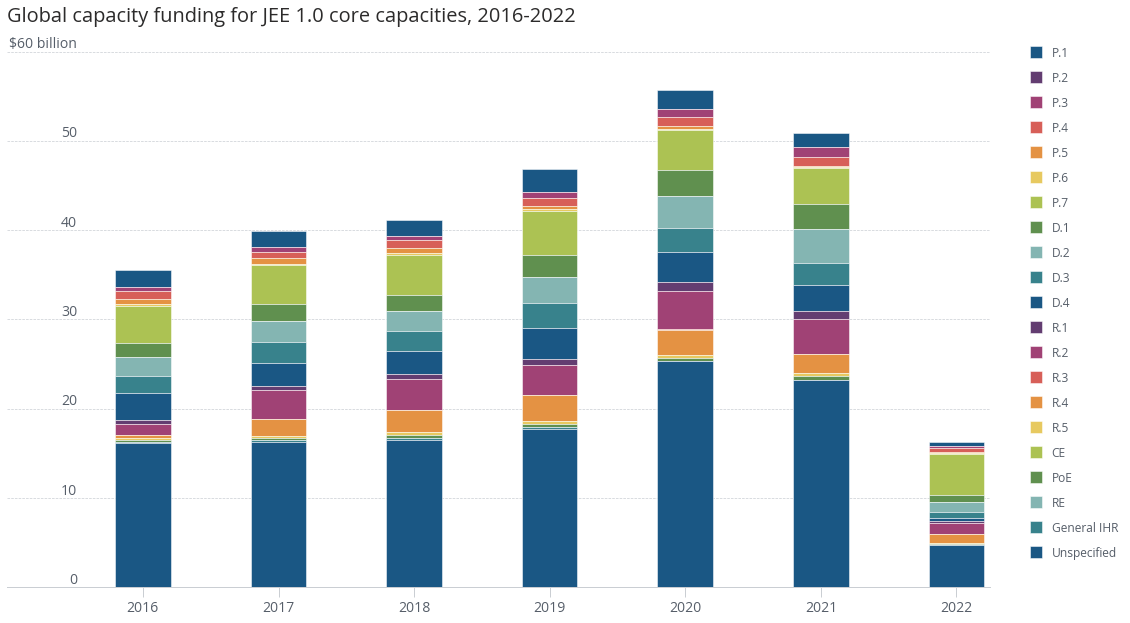

In [313]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Define variables
x=pivot_df['Date']
y1=pivot_df['P.1']
y2=pivot_df['P.2']
y3=pivot_df['P.3']
y4=pivot_df['P.4']
y5=pivot_df['P.5']
y6=pivot_df['P.6']
y7=pivot_df['P.7']
y8= pivot_df['D.1']
y9 = pivot_df['D.2']
y10 =pivot_df['D.3']
y11 =pivot_df['D.4']
y12 =pivot_df['R.1']
y13 =pivot_df['R.2']
y14 =pivot_df['R.3']
y15 =pivot_df['R.4']
y16 =pivot_df['R.5']
y17 =pivot_df['CE']
y18 =pivot_df['PoE']
y19 =pivot_df['RE']
y20 =pivot_df['General IHR']
y21 =pivot_df['Unspecified']

# Plot bars
# The thing that gets plotted last in this list gets plotted on the bottom
bar_width = 150
plt.bar(x, y1, bottom=y21+y20+y19+y18+y17+y16+y15+y14+y13+y12+y11+y10+y9+y8+y7+y6+y5+y4+y3+y2, linewidth=0.5, width=bar_width, align="center", color=colors[0], label='P.1')
plt.bar(x, y2, bottom=y21+y20+y19+y18+y17+y16+y15+y14+y13+y12+y11+y10+y9+y8+y7+y6+y5+y4+y3, linewidth=0.5, width=bar_width, align="center", color=colors[9], label='P.2')
plt.bar(x, y3, bottom=y21+y20+y19+y18+y17+y16+y15+y14+y13+y12+y11+y10+y9+y8+y7+y6+y5+y4, linewidth=0.5, width=bar_width, align="center", color=colors[8], label='P.3')
plt.bar(x, y4, bottom=y21+y20+y19+y18+y17+y16+y15+y14+y13+y12+y11+y10+y9+y8+y7+y6+y5, linewidth=0.5, width=bar_width, align="center", color=colors[7], label='P.4')
plt.bar(x, y5, bottom=y21+y20+y19+y18+y17+y16+y15+y14+y13+y12+y11+y10+y9+y8+y7+y6, linewidth=0.5, width=bar_width, align="center", color=colors[6], label='P.5')
plt.bar(x, y6, bottom=y21+y20+y19+y18+y17+y16+y15+y14+y13+y12+y11+y10+y9+y8+y7, linewidth=0.5, width=bar_width, align="center", color=colors[5], label='P.6')
plt.bar(x, y7, bottom=y21+y20+y19+y18+y17+y16+y15+y14+y13+y12+y11+y10+y9+y8, linewidth=0.5, width=bar_width, align="center", color=colors[4], label='P.7')
plt.bar(x, y8, bottom=y21+y20+y19+y18+y17+y16+y15+y14+y13+y12+y11+y10+y9, linewidth=0.5, width=bar_width, align="center", color=colors[3], label='D.1')
plt.bar(x, y9, bottom=y21+y20+y19+y18+y17+y16+y15+y14+y13+y12+y11+y10, linewidth=0.5, width=bar_width, align="center", color=colors[2], label='D.2')
plt.bar(x, y10, bottom=y21+y20+y19+y18+y17+y16+y15+y14+y13+y12+y11, linewidth=0.5, width=bar_width, align="center", color=colors[1], label='D.3')
plt.bar(x, y11, bottom=y21+y20+y19+y18+y17+y16+y15+y14+y13+y12, linewidth=0.5, width=bar_width, align="center", color=colors[0], label='D.4')
plt.bar(x, y12, bottom=y21+y20+y19+y18+y17+y16+y15+y14+y13, linewidth=0.5, width=bar_width, align="center", color=colors[9], label='R.1')
plt.bar(x, y13, bottom=y21+y20+y19+y18+y17+y16+y15+y14, linewidth=0.5, width=bar_width, align="center", color=colors[8], label='R.2')
plt.bar(x, y14, bottom=y21+y20+y19+y18+y17+y16+y15, linewidth=0.5, width=bar_width, align="center", color=colors[7], label='R.3')
plt.bar(x, y15, bottom=y21+y20+y19+y18+y17+y16, linewidth=0.5, width=bar_width, align="center", color=colors[6], label='R.4')
plt.bar(x, y16, bottom=y21+y20+y19+y18+y17, linewidth=0.5, width=bar_width, align="center", color=colors[5], label='R.5')
plt.bar(x, y17, bottom=y21+y20+y19+y18, linewidth=0.5, width=bar_width, align="center", color=colors[4], label='CE')
plt.bar(x, y18, bottom=y21+y20+y19, linewidth=0.5, width=bar_width, align="center", color=colors[3], label='PoE')
plt.bar(x, y19, bottom=y21+y20, linewidth=0.5, width=bar_width, align="center", color=colors[2], label='RE')
plt.bar(x, y20, bottom=y21, linewidth=0.5, width=bar_width, align="center", color=colors[1], label='General IHR')
plt.bar(x, y21, bottom=0, linewidth=0.5, width=bar_width, align="center", color=colors[0], label='Unspecified')


# ax.xaxis_date()

# Define x-axis range
left = dt.date(2015,1,1)
right = dt.date(2022,4,1)

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,60e9)

# Set title
title = "Global capacity funding for JEE 1.0 core capacities, 2016-2022"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['${:,.0f} billion'.format(y / 1e9) if i == 6 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-70) 

# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.03,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)


plt.tight_layout()
# plt.show()
# plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/global_core_capacity_2016-22.png', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait',bbox_inches='tight')

### Area chart

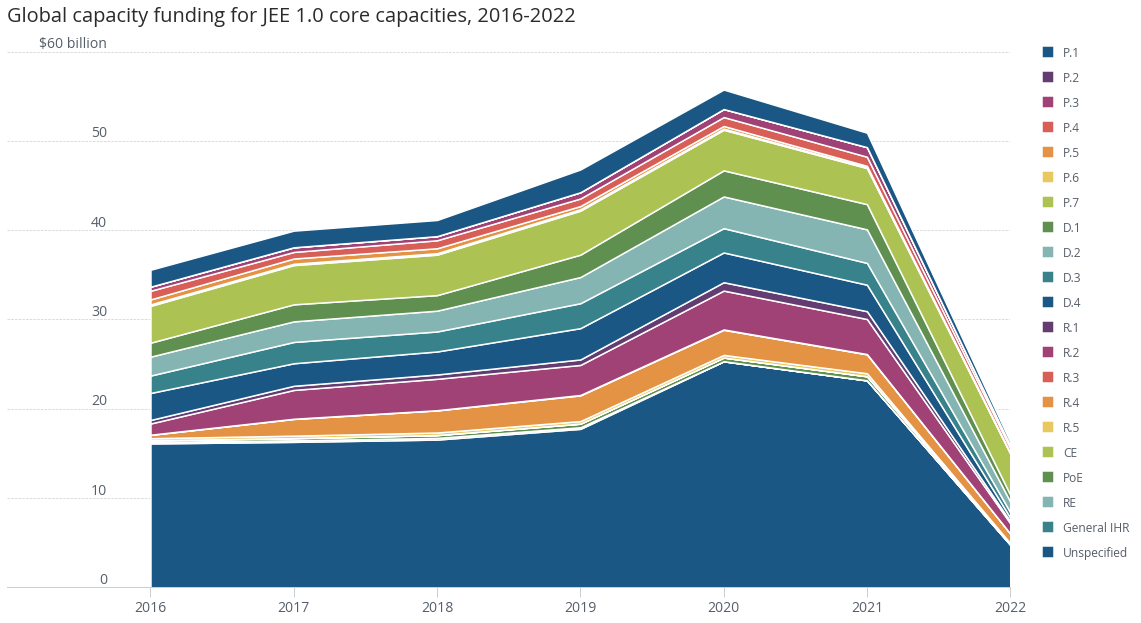

In [311]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Combine y-values into a list of lists
y_values = [y1, y2, y3, y4, y5, y6, y7, y8, y9, y10, y11, y12, y13, y14, y15, y16, y17, y18, y19, y20, y21]
reversed_y_values = [y21, y20, y19, y18, y17, y16, y15, y14, y13, y12, y11, y10, y9, y8, y7, y6, y5, y4, y3, y2, y1]


x = [2016, 2017, 2018, 2019, 2020, 2021, 2022]

reversed_labels = ['Unspecified', 'General IHR', 'RE', 'PoE', 'CE', 'R.5', 'R.4', 'R.3', 'R.2', 'R.1', 'D.4', 'D.3', 'D.2', 'D.1', 'P.7', 'P.6', 'P.5', 'P.4', 'P.3', 'P.2', 'P.1']
labels = ['P.1', 'P.2', 'P.3', 'P.4', 'P.5', 'P.6', 'P.7', 'D.1', 'D.2', 'D.3', 'D.4', 'R.1', 'R.2', 'R.3', 'R.4', 'R.5', 'CE', 'PoE', 'RE', 'General IHR', 'Unspecified']

# Stackplot using x and y_values
plt.stackplot(x, reversed_y_values, colors = colors, labels=labels)

# Define x-axis range
left = 2015
right = 2022

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,60e9)

# Set title
title = "Global capacity funding for JEE 1.0 core capacities, 2016-2022"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['${:,.0f} billion'.format(y / 1e9) if i == 6 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-100) 

# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
handles.reverse()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.13,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

plt.tight_layout()
# plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/global_core_capacity_area_2016-22.png', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait',bbox_inches='tight')

### Relative proportions

In [432]:
# Extract the columns you want to calculate proportions for
columns_to_calculate = ['CE', 'D.1', 'D.2', 'D.3', 'D.4', 'General IHR', 'P.1', 'P.2', 'P.3', 'P.4', 'P.5', 'P.6', 'P.7', 'PoE', 'R.1', 'R.2', 'R.3', 'R.4', 'R.5', 'RE', 'Unspecified']

relative_proportions = pivot_df.reset_index()

# Calculate relative proportions for each column for each year
relative_proportions = relative_proportions.groupby('Date')[columns_to_calculate].apply(lambda x: x.div(x.sum(axis=1), axis=0) * 100)

relative_proportions['Date'] = pd.to_datetime(['2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01','2021-01-01','2022-01-01'])

relative_proportions

Core capacity code,CE,D.1,D.2,D.3,D.4,General IHR,P.1,P.2,P.3,P.4,...,P.7,PoE,R.1,R.2,R.3,R.4,R.5,RE,Unspecified,Date
0,0.023399,4.399010,5.952057,5.490226,8.497513,0.478901,5.333897,0.004921,1.281867,2.722466,...,11.595907,0.491314,1.113205,3.524562,0.061721,1.044164,0.641047,0.015922,45.298486,2016-01-01
1,0.029018,4.778483,5.769561,5.975211,6.321519,0.434430,4.665135,0.012696,1.291306,1.840655,...,11.002032,0.589081,1.156569,8.076284,0.062705,4.678694,0.688715,0.007178,40.773626,2017-01-01
2,0.032642,4.232429,5.661761,5.445132,6.261848,0.449216,4.396088,0.013042,1.112277,2.175045,...,11.012912,0.752459,1.178960,8.551426,0.054074,6.010797,0.689791,0.007902,40.214587,2018-01-01
3,0.015987,5.352502,6.265947,5.968892,7.490371,0.372725,5.449730,0.009420,1.487788,1.806889,...,10.532526,0.853838,1.312079,7.187007,0.101984,6.148052,0.613121,0.006862,37.919132,2019-01-01
4,0.002451,5.241797,6.374911,4.880995,5.974186,0.000020,3.910074,0.003388,1.611680,1.788841,...,8.155458,0.730504,1.686937,7.800588,0.069082,5.048428,0.534362,0.015334,45.408689,2020-01-01
5,0.002220,5.548735,7.379101,4.799086,5.825826,0.000000,3.174514,0.001877,2.105802,2.009020,...,7.932048,0.890534,1.723472,7.700176,0.071820,4.153226,0.664602,0.018993,45.511614,2021-01-01
6,0.000000,4.762561,7.294547,3.728325,2.411155,0.000000,2.683630,0.003458,1.702434,3.025836,...,28.200200,0.565263,1.398137,7.073946,0.036822,6.533127,0.555678,0.025218,29.197509,2022-01-01


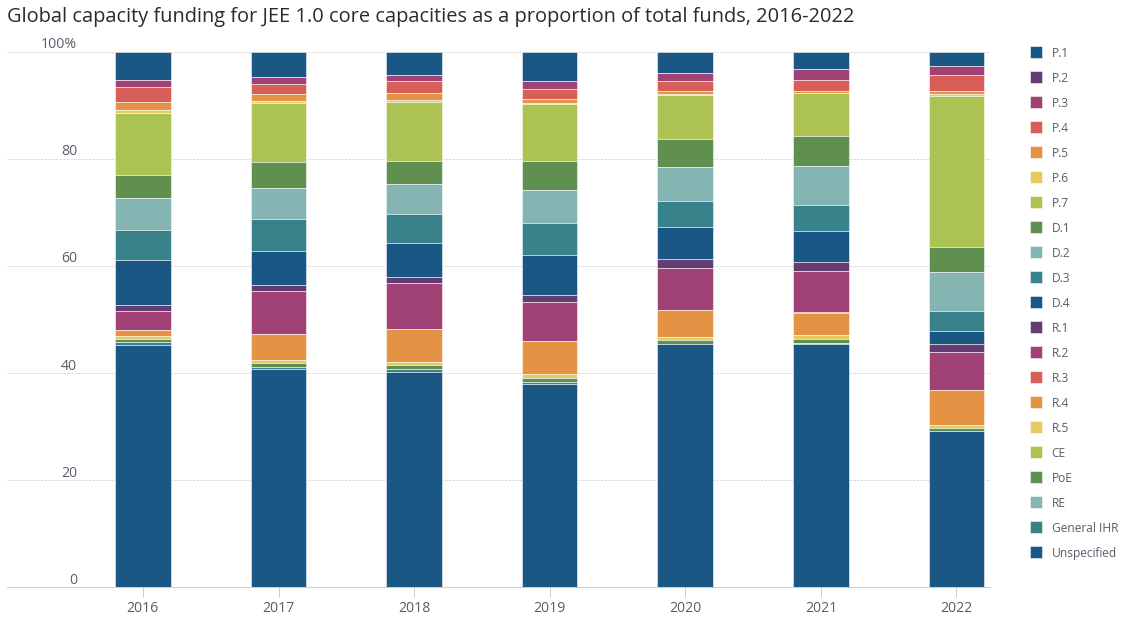

In [316]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Define variables
x=relative_proportions['Date']
y1=relative_proportions['P.1']
y2=relative_proportions['P.2']
y3=relative_proportions['P.3']
y4=relative_proportions['P.4']
y5=relative_proportions['P.5']
y6=relative_proportions['P.6']
y7=relative_proportions['P.7']
y8= relative_proportions['D.1']
y9 = relative_proportions['D.2']
y10 =relative_proportions['D.3']
y11 =relative_proportions['D.4']
y12 =relative_proportions['R.1']
y13 =relative_proportions['R.2']
y14 =relative_proportions['R.3']
y15 =relative_proportions['R.4']
y16 =relative_proportions['R.5']
y17 =relative_proportions['CE']
y18 =relative_proportions['PoE']
y19 =relative_proportions['RE']
y20 =relative_proportions['General IHR']
y21 =relative_proportions['Unspecified']

# Plot bars
# The thing that gets plotted last in this list gets plotted on the bottom
bar_width = 150
plt.bar(x, y1, bottom=y21+y20+y19+y18+y17+y16+y15+y14+y13+y12+y11+y10+y9+y8+y7+y6+y5+y4+y3+y2, linewidth=0.5, width=bar_width, align="center", color=colors[0], label='P.1')
plt.bar(x, y2, bottom=y21+y20+y19+y18+y17+y16+y15+y14+y13+y12+y11+y10+y9+y8+y7+y6+y5+y4+y3, linewidth=0.5, width=bar_width, align="center", color=colors[9], label='P.2')
plt.bar(x, y3, bottom=y21+y20+y19+y18+y17+y16+y15+y14+y13+y12+y11+y10+y9+y8+y7+y6+y5+y4, linewidth=0.5, width=bar_width, align="center", color=colors[8], label='P.3')
plt.bar(x, y4, bottom=y21+y20+y19+y18+y17+y16+y15+y14+y13+y12+y11+y10+y9+y8+y7+y6+y5, linewidth=0.5, width=bar_width, align="center", color=colors[7], label='P.4')
plt.bar(x, y5, bottom=y21+y20+y19+y18+y17+y16+y15+y14+y13+y12+y11+y10+y9+y8+y7+y6, linewidth=0.5, width=bar_width, align="center", color=colors[6], label='P.5')
plt.bar(x, y6, bottom=y21+y20+y19+y18+y17+y16+y15+y14+y13+y12+y11+y10+y9+y8+y7, linewidth=0.5, width=bar_width, align="center", color=colors[5], label='P.6')
plt.bar(x, y7, bottom=y21+y20+y19+y18+y17+y16+y15+y14+y13+y12+y11+y10+y9+y8, linewidth=0.5, width=bar_width, align="center", color=colors[4], label='P.7')
plt.bar(x, y8, bottom=y21+y20+y19+y18+y17+y16+y15+y14+y13+y12+y11+y10+y9, linewidth=0.5, width=bar_width, align="center", color=colors[3], label='D.1')
plt.bar(x, y9, bottom=y21+y20+y19+y18+y17+y16+y15+y14+y13+y12+y11+y10, linewidth=0.5, width=bar_width, align="center", color=colors[2], label='D.2')
plt.bar(x, y10, bottom=y21+y20+y19+y18+y17+y16+y15+y14+y13+y12+y11, linewidth=0.5, width=bar_width, align="center", color=colors[1], label='D.3')
plt.bar(x, y11, bottom=y21+y20+y19+y18+y17+y16+y15+y14+y13+y12, linewidth=0.5, width=bar_width, align="center", color=colors[0], label='D.4')
plt.bar(x, y12, bottom=y21+y20+y19+y18+y17+y16+y15+y14+y13, linewidth=0.5, width=bar_width, align="center", color=colors[9], label='R.1')
plt.bar(x, y13, bottom=y21+y20+y19+y18+y17+y16+y15+y14, linewidth=0.5, width=bar_width, align="center", color=colors[8], label='R.2')
plt.bar(x, y14, bottom=y21+y20+y19+y18+y17+y16+y15, linewidth=0.5, width=bar_width, align="center", color=colors[7], label='R.3')
plt.bar(x, y15, bottom=y21+y20+y19+y18+y17+y16, linewidth=0.5, width=bar_width, align="center", color=colors[6], label='R.4')
plt.bar(x, y16, bottom=y21+y20+y19+y18+y17, linewidth=0.5, width=bar_width, align="center", color=colors[5], label='R.5')
plt.bar(x, y17, bottom=y21+y20+y19+y18, linewidth=0.5, width=bar_width, align="center", color=colors[4], label='CE')
plt.bar(x, y18, bottom=y21+y20+y19, linewidth=0.5, width=bar_width, align="center", color=colors[3], label='PoE')
plt.bar(x, y19, bottom=y21+y20, linewidth=0.5, width=bar_width, align="center", color=colors[2], label='RE')
plt.bar(x, y20, bottom=y21, linewidth=0.5, width=bar_width, align="center", color=colors[1], label='General IHR')
plt.bar(x, y21, bottom=0, linewidth=0.5, width=bar_width, align="center", color=colors[0], label='Unspecified')


# ax.xaxis_date()

# Define x-axis range
left = dt.date(2015,1,1)
right = dt.date(2022,4,1)

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,100)

# Set title
title = "Global capacity funding for JEE 1.0 core capacities as a proportion of total funds, 2016-2022"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['{:,.0f}%'.format(y) if i == 5 else '{:,.0f}'.format(y) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-70) 

# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.03,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)


plt.tight_layout()
# plt.show()
# plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/global_core_capacity_relative_2016-22.png', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait',bbox_inches='tight')

### Major core areas (instead of capacities)
- Global capacity funding
- P, D, R
- 2016-2022

In [433]:
pivot_df['Prevent'] = pivot_df['P.1'] + pivot_df['P.2'] + pivot_df['P.3'] + pivot_df['P.4'] + pivot_df['P.5'] + pivot_df['P.6'] + pivot_df['P.7']
pivot_df['Detect'] = pivot_df['D.1'] + pivot_df['D.2'] + pivot_df['D.3'] + pivot_df['D.4']
pivot_df['Respond'] = pivot_df['R.1'] + pivot_df['R.2'] + pivot_df['R.3'] + pivot_df['R.4'] + pivot_df['R.5'] 
pivot_df['IHR Related Hazards'] = pivot_df['CE'] + pivot_df['RE'] + pivot_df['PoE']
pivot_df['Not specified'] = pivot_df['General IHR'] + pivot_df['Unspecified']

In [434]:
# Calculate percentages for each category
pivot_df['Prevent (%)'] = (pivot_df['Prevent'] / pivot_df['Total']) * 100
pivot_df['Detect (%)'] = (pivot_df['Detect'] / pivot_df['Total']) * 100
pivot_df['Respond (%)'] = (pivot_df['Respond'] / pivot_df['Total']) * 100
pivot_df['IHR Related Hazards (%)'] = (pivot_df['IHR Related Hazards'] / pivot_df['Total']) * 100
pivot_df['Not specified (%)'] = (pivot_df['Not specified'] / pivot_df['Total']) * 100

# Calculate the average for each column
average_values = pivot_df[['Prevent (%)', 'Detect (%)', 'Respond (%)', 'IHR Related Hazards (%)', 'Not specified (%)']].mean()

# Display the average values
print(average_values)

Core capacity code
Prevent (%)                21.833700
Detect (%)                 22.583384
Respond (%)                13.992194
IHR Related Hazards (%)     0.725160
Not specified (%)          40.865562
dtype: float64


### Stacked bar chart

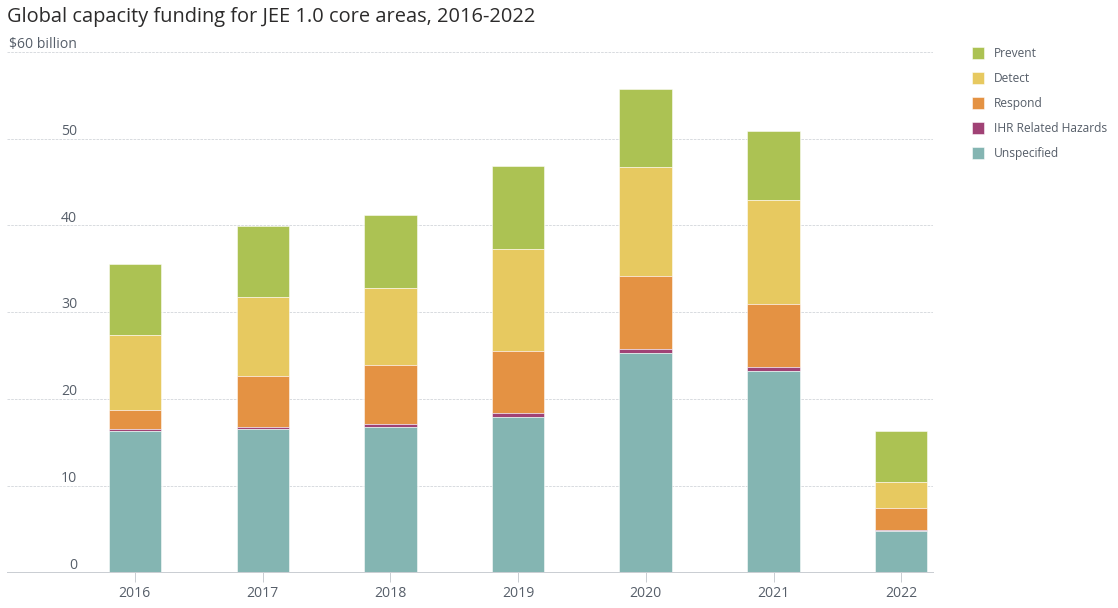

In [321]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Define variables
x=pivot_df['Date']
y1=pivot_df['Prevent'] 
y2=pivot_df['Detect']
y3=pivot_df['Respond']
y4=pivot_df['IHR Related Hazards']
y5=pivot_df['Not specified']


# Plot bars
# The thing that gets plotted last in this list gets plotted on the bottom
bar_width = 150
plt.bar(x, y1, bottom=y5+y4+y3+y2, linewidth=0.5, width=bar_width, align="center", color=colors[4], label='Prevent')
plt.bar(x, y2, bottom=y5+y4+y3, linewidth=0.5, width=bar_width, align="center", color=colors[5], label='Detect')
plt.bar(x, y3, bottom=y5+y4, linewidth=0.5, width=bar_width, align="center", color=colors[6], label='Respond')
plt.bar(x, y4, bottom=y5, linewidth=0.5, width=bar_width, align="center", color=colors[8], label='IHR Related Hazards')
plt.bar(x, y5, bottom=0, linewidth=0.5, width=bar_width, align="center", color=colors[2], label='Unspecified')


# ax.xaxis_date()

# Define x-axis range
left = dt.date(2015,1,1)
right = dt.date(2022,4,1)

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,60e9)

# Set title
title = "Global capacity funding for JEE 1.0 core areas, 2016-2022"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['${:,.0f} billion'.format(y / 1e9) if i == 6 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-70) 

# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.2,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

plt.tight_layout(pad = 1.5)
# plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/global_core_areas_2016-22.png', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait')

### Area chart

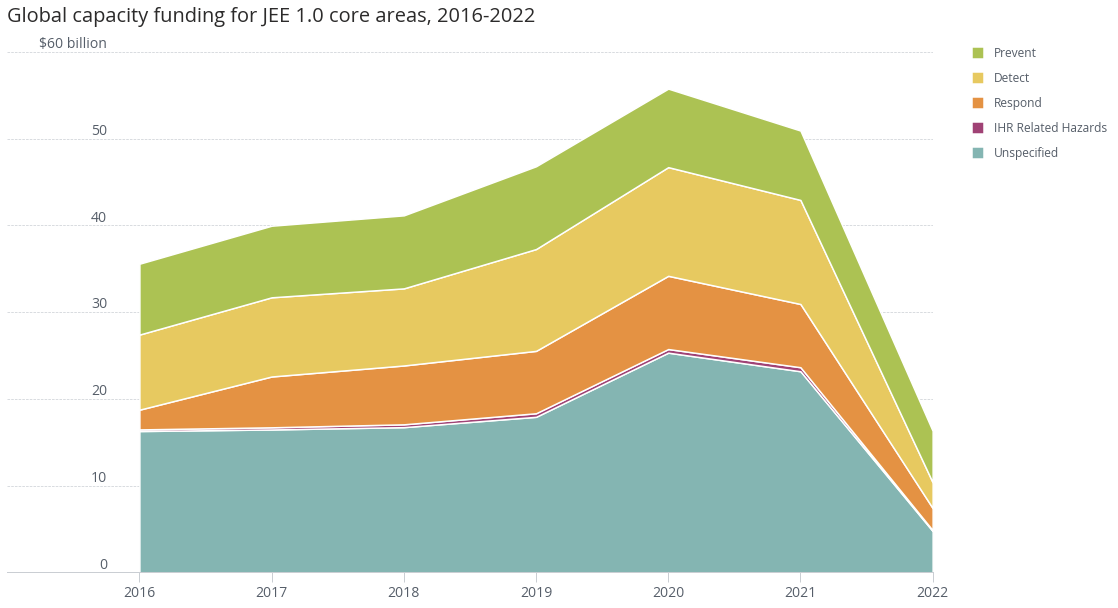

In [328]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Combine y-values into a list of lists
reversed_y_values = [y5, y4, y3, y2, y1]


x = [2016, 2017, 2018, 2019, 2020, 2021, 2022]

labels = ['Prevent','Detect','Respond','IHR Related Hazards','Unspecified']

# Stackplot using x and y_values
plt.stackplot(x, reversed_y_values, colors = [colors[2],colors[8],colors[6],colors[5],colors[4]], labels=labels)

# Define x-axis range
left = 2015
right = 2022

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,60e9)

# Set title
title = "Global capacity funding for JEE 1.0 core areas, 2016-2022"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['${:,.0f} billion'.format(y / 1e9) if i == 6 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-100) 

# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
handles.reverse()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.2,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

plt.tight_layout(pad=1.5)
# plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/global_core_capacity_area_area_2016-22.png', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait')

### Relative proportion

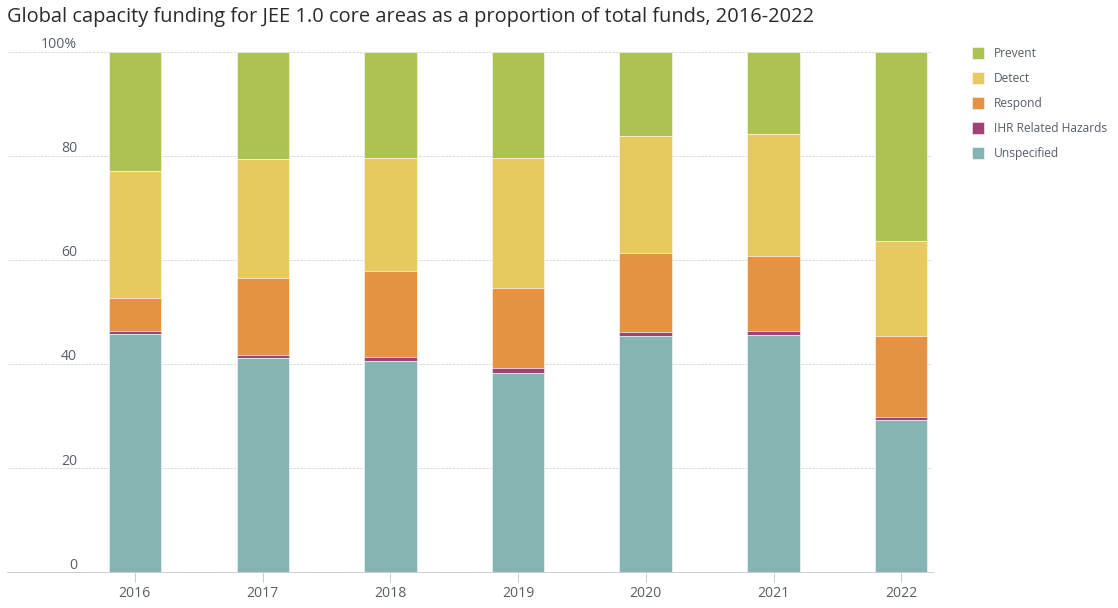

In [437]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Define variables
x=pivot_df['Date']
y1=pivot_df['Prevent (%)'] 
y2=pivot_df['Detect (%)']
y3=pivot_df['Respond (%)']
y4=pivot_df['IHR Related Hazards (%)']
y5=pivot_df['Not specified (%)']


# Plot bars
# The thing that gets plotted last in this list gets plotted on the bottom
bar_width = 150
plt.bar(x, y1, bottom=y5+y4+y3+y2, linewidth=0.5, width=bar_width, align="center", color=colors[4], label='Prevent')
plt.bar(x, y2, bottom=y5+y4+y3, linewidth=0.5, width=bar_width, align="center", color=colors[5], label='Detect')
plt.bar(x, y3, bottom=y5+y4, linewidth=0.5, width=bar_width, align="center", color=colors[6], label='Respond')
plt.bar(x, y4, bottom=y5, linewidth=0.5, width=bar_width, align="center", color=colors[8], label='IHR Related Hazards')
plt.bar(x, y5, bottom=0, linewidth=0.5, width=bar_width, align="center", color=colors[2], label='Unspecified')


# ax.xaxis_date()

# Define x-axis range
left = dt.date(2015,1,1)
right = dt.date(2022,4,1)

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,100)

# Set title
title = "Global capacity funding for JEE 1.0 core areas as a proportion of total funds, 2016-2022"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['{:,.0f}%'.format(y) if i == 5 else '{:,.0f}'.format(y) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-70) 

# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.2,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

plt.tight_layout(pad = 1.5)
plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/global_core_areas_relative_2016-22.png', dpi=1200, facecolor='w', 
            edgecolor='w', 
            orientation='portrait')

In [438]:
pivot_df

Core capacity code,Date,CE,D.1,D.2,D.3,D.4,General IHR,P.1,P.2,P.3,...,Prevent,Detect,Respond,IHR Related Hazards,Not specified,Prevent (%),Detect (%),Respond (%),IHR Related Hazards (%),Not specified (%)
0,2016-01-01,8.323290e+06,1.564751e+09,2.117178e+09,1.952902e+09,3.022609e+09,1.703476e+08,1.897295e+09,1.750387e+06,4.559669e+08,...,8.170005e+09,8.657440e+09,2.271071e+09,1.887497e+08,1.628325e+10,22.968472,24.338806,6.384699,0.530635,45.777387
1,2017-01-01,1.159334e+07,1.909114e+09,2.305072e+09,2.387235e+09,2.525592e+09,1.735650e+08,1.863829e+09,5.072462e+06,5.159066e+08,...,8.253718e+09,9.127013e+09,5.858193e+09,2.498124e+08,1.646357e+10,20.658927,22.844773,14.662967,0.625276,41.208057
2,2018-01-01,1.343072e+07,1.741470e+09,2.329582e+09,2.240448e+09,2.576493e+09,1.848338e+08,1.808810e+09,5.366373e+06,4.576564e+08,...,8.417204e+09,8.887994e+09,6.782920e+09,3.262883e+08,1.673148e+10,20.456975,21.601171,16.485048,0.793003,40.663802
3,2019-01-01,7.482768e+06,2.505270e+09,2.932813e+09,2.793775e+09,3.505912e+09,1.744563e+08,2.550778e+09,4.408997e+06,6.963680e+08,...,9.544359e+09,1.173777e+10,7.190387e+09,4.103385e+08,1.792273e+10,20.391499,25.077713,15.362243,0.876687,38.291858
4,2020-01-01,1.366293e+06,2.922568e+09,3.554336e+09,2.721402e+09,3.330912e+09,1.100000e+04,2.180065e+09,1.888991e+06,8.985932e+08,...,9.050007e+09,1.252922e+10,8.440983e+09,4.172087e+08,2.531766e+10,16.231717,22.471888,15.139398,0.748288,45.408709
5,2021-01-01,1.130282e+06,2.825560e+09,3.757630e+09,2.443819e+09,2.966662e+09,0.000000e+00,1.616545e+09,9.556573e+05,1.072329e+09,...,8.000245e+09,1.199367e+10,7.288703e+09,4.642853e+08,2.317570e+10,15.710596,23.552747,14.313296,0.911747,45.511614
6,2022-01-01,0.000000e+00,7.767984e+08,1.189778e+09,6.081092e+08,3.932720e+08,0.000000e+00,4.377140e+08,5.640624e+05,2.776758e+08,...,5.939919e+09,2.967958e+09,2.544068e+09,9.631044e+07,4.762266e+09,36.417714,18.196587,15.597710,0.590480,29.197509


### Percent change

In [435]:
# Set 'Date' as the index
yearly_change = pivot_df.copy()

yearly_change.set_index('Date', inplace=True)

# Calculate the percentage change for each column
yearly_change = yearly_change.pct_change() * 100

# Reset index if you want 'Date' as a column again
yearly_change.reset_index(inplace=True)

# Display the DataFrame with percentage changes
yearly_change

Core capacity code,Date,CE,D.1,D.2,D.3,D.4,General IHR,P.1,P.2,P.3,...,Prevent,Detect,Respond,IHR Related Hazards,Not specified,Prevent (%),Detect (%),Respond (%),IHR Related Hazards (%),Not specified (%)
0,2016-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-01,39.287973,22.007558,8.874779,22.240367,-16.443306,1.888720,-1.763864,189.790933,13.145626,...,1.024637,5.423935,157.948527,32.351104,1.107362,-10.055285,-6.138481,129.657909,17.835438,-9.981632
2,2018-01-01,15.848563,-8.781228,1.063289,-6.148806,2.015401,6.492572,-2.951964,5.794238,-11.290849,...,1.980763,-2.618816,15.785179,30.613365,1.627316,-0.977553,-5.443705,12.426416,26.824458,-1.320747
3,2019-01-01,-44.286169,43.859443,25.894386,24.697138,36.073008,-5.614513,41.019702,-17.840282,52.159563,...,13.391087,32.063201,6.007260,25.759475,7.119772,-0.320069,16.094229,-6.811049,10.552745,-5.833061
4,2020-01-01,-81.740810,16.656824,21.192058,-2.590487,-4.991567,-99.993695,-14.533327,-57.155996,29.040003,...,-5.179528,6.742759,17.392606,1.674280,41.260099,-20.399587,-10.391000,-1.450607,-14.645914,18.585808
5,2021-01-01,-17.273821,-3.319257,5.719599,-10.199993,-10.935435,-100.000000,-25.848754,-49.409103,19.334209,...,-11.599572,-4.274379,-13.651013,11.283698,-8.460345,-3.210514,4.809828,-5.456633,21.844341,0.226620
6,2022-01-01,-100.000000,-72.508163,-68.337000,-75.116445,-86.743621,NaN,-72.922877,-40.976498,-74.105352,...,-25.753287,-75.253967,-65.095745,-79.256194,-79.451470,131.803520,-22.741125,8.973569,-35.236361,-35.846027


In [436]:
total_change = pivot_df.copy()

total_change.set_index('Date', inplace=True)

# Select the first and last rows
first_row = total_change.iloc[0]
last_row = total_change.iloc[-1]

# Calculate the percentage change between the first and last row
total_change = ((last_row - first_row) / first_row) * 100

# Display the percentage change
total_change


Core capacity code
CE                        -100.000000
D.1                        -50.356406
D.2                        -43.803559
D.3                        -68.861256
D.4                        -86.988991
General IHR               -100.000000
P.1                        -76.929575
P.2                        -67.774983
P.3                        -39.101756
P.4                        -49.036360
P.5                        -88.053161
P.6                        -61.022572
P.7                         11.512891
PoE                        -47.244345
R.1                        -42.409327
R.2                         -7.968986
R.3                        -72.644314
R.4                        186.899694
R.5                        -60.252408
RE                         -27.375611
Unspecified                -70.444404
Total                      -54.145959
Prevent                    -27.296020
Detect                     -65.717831
Respond                     12.020628
IHR Related Hazards        -48.

### Integrated response funding
- Global capacity and response funding
- Core capacities and response
- 2016-2022

In [439]:
# Load data
raw = pd.read_csv('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/analyses/Core capacities over time (response funding)/results/Core capacities over time (response funding)__latest.csv')

# Clean data, converting year from numeric to datetime, and dropping the calculated columns
raw['Year'] = pd.to_datetime(raw['Year'], format='%Y').dt.year
raw['Date'] = pd.to_datetime(raw['Year'].astype(str) + '-01-01')

# Filter the DataFrame to only include rows in 2016-2022 range
df = raw[raw['Year'] >= 2016]
df = df[df['Year'] <= 2022]

# Show data
df.head()

,Core capacity,Core capacity code,Year,Amount disbursed for year for capacity (nominal USD),Date
0,Biosafety and Biosecurity,P.6,2017,712634.823125,2017-01-01
1,Biosafety and Biosecurity,P.6,2018,713374.578000,2018-01-01
2,Biosafety and Biosecurity,P.6,2019,696315.924100,2019-01-01
3,Biosafety and Biosecurity,P.6,2020,696315.924100,2020-01-01
4,Biosafety and Biosecurity,P.6,2021,696315.924100,2021-01-01


In [440]:
# Pivot the DataFrame with species as columns
response_pivot_df = df.pivot_table(index='Date', columns='Core capacity code', values='Amount disbursed for year for capacity (nominal USD)', aggfunc = 'sum',fill_value=0)

# Flatten the DataFrame
response_pivot_df.reset_index(inplace=True)

response_pivot_df['Total'] = response_pivot_df.sum(axis=1)

response_pivot_df

Core capacity code,Date,D.1,D.2,D.4,General IHR,P.1,P.4,P.6,P.7,PoE,R.1,R.2,R.4,R.5,Unspecified,Total
0,2016-01-01,0.000000e+00,1.500000e+08,1.873333e+05,198000,0.000000e+00,0.0000,0.000000,0.000000e+00,0,6.396075e+06,1.764189e+06,2.206667e+05,0,1.794616e+09,1.953382e+09
1,2017-01-01,0.000000e+00,1.797637e+05,0.000000e+00,0,0.000000e+00,0.0000,712634.823125,0.000000e+00,0,0.000000e+00,1.691132e+06,7.267591e+06,0,1.295563e+09,1.305414e+09
2,2018-01-01,0.000000e+00,1.517995e+07,0.000000e+00,0,0.000000e+00,360295.4424,713374.578000,0.000000e+00,0,0.000000e+00,7.133292e+07,7.275135e+06,0,9.822695e+08,1.077131e+09
3,2019-01-01,2.333333e+05,9.572148e+05,2.333333e+05,0,0.000000e+00,0.0000,696315.924100,0.000000e+00,0,8.620000e+06,0.000000e+00,7.101168e+06,0,1.834431e+09,1.852272e+09
4,2020-01-01,2.333333e+05,2.285721e+07,3.233333e+06,0,0.000000e+00,0.0000,696315.924100,1.422412e+09,3000000,1.803923e+09,1.803923e+09,8.983103e+06,0,2.612477e+10,3.119403e+10
5,2021-01-01,2.347770e+06,9.572148e+05,5.347770e+06,0,2.114436e+06,0.0000,696315.924100,0.000000e+00,3000000,1.498798e+09,1.498798e+09,8.983103e+06,0,3.986277e+10,4.288382e+10
6,2022-01-01,2.114436e+06,9.572148e+05,5.114436e+06,0,2.114436e+06,0.0000,696315.924100,0.000000e+00,3000000,0.000000e+00,0.000000e+00,7.101168e+06,1450000,6.811282e+09,6.833830e+09


In [441]:
pivot_df['Response (%)'] =  (response_pivot_df['Total'] / (response_pivot_df['Total'] + pivot_df['Total'])) * 100

In [446]:
pivot_df['Total']

0    3.557052e+10
1    3.995231e+10
2    4.114589e+10
3    4.680558e+10
4    5.575508e+10
5    5.092260e+10
6    1.631052e+10
Name: Total, dtype: float64

### Stacked bar chart

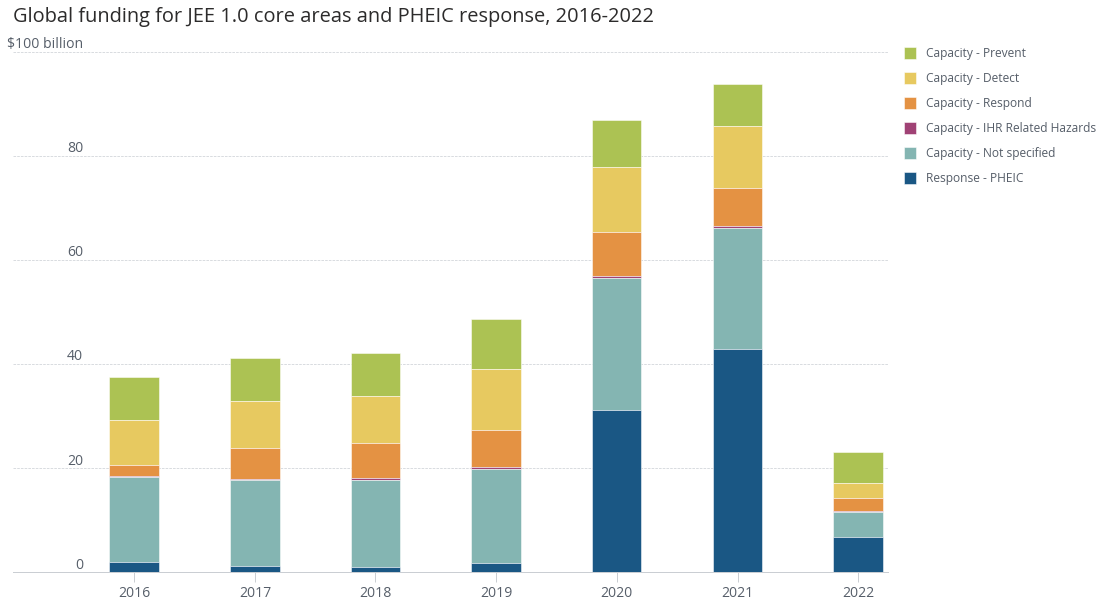

In [363]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Define variables
x=pivot_df['Date']
y1=pivot_df['Prevent'] 
y2=pivot_df['Detect']
y3=pivot_df['Respond']
y4=pivot_df['IHR Related Hazards']
y5=pivot_df['Not specified']
y6 = response_pivot_df['Total']


# Plot bars
# The thing that gets plotted last in this list gets plotted on the bottom
bar_width = 150
plt.bar(x, y1, bottom=y6+y5+y4+y3+y2, linewidth=0.5, width=bar_width, align="center", color=colors[4], label='Capacity - Prevent')
plt.bar(x, y2, bottom=y6+y5+y4+y3, linewidth=0.5, width=bar_width, align="center", color=colors[5], label='Capacity - Detect')
plt.bar(x, y3, bottom=y6+y5+y4, linewidth=0.5, width=bar_width, align="center", color=colors[6], label='Capacity - Respond')
plt.bar(x, y4, bottom=y6+y5, linewidth=0.5, width=bar_width, align="center", color=colors[8], label='Capacity - IHR Related Hazards')
plt.bar(x, y5, bottom=y6, linewidth=0.5, width=bar_width, align="center", color=colors[2], label='Capacity - Not specified')
plt.bar(x, y6, bottom=0, linewidth=0.5, width=bar_width, align="center", color=colors[0], label='Response - PHEIC')



# ax.xaxis_date()

# Define x-axis range
left = dt.date(2015,1,1)
right = dt.date(2022,4,1)

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,100e9)

# Set title
title = "Global funding for JEE 1.0 core areas and PHEIC response, 2016-2022"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['${:,.0f} billion'.format(y / 1e9) if i == 5 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-70) 

# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.25,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

plt.tight_layout(pad = 1.5)
# plt.show()
# plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/global_capacity_and_response_2016-22.png', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait')

### Area chart

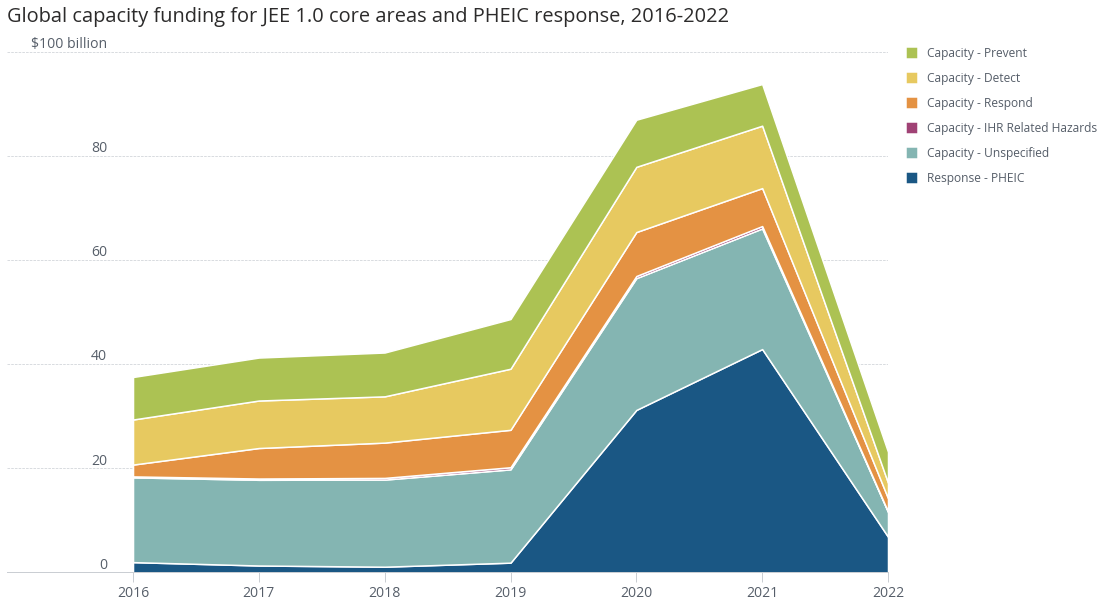

In [370]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Combine y-values into a list of lists
reversed_y_values = [y6, y5, y4, y3, y2, y1]


x = [2016, 2017, 2018, 2019, 2020, 2021, 2022]

labels = ['Capacity - Prevent','Capacity - Detect','Capacity - Respond','Capacity - IHR Related Hazards','Capacity - Unspecified', 'Response - PHEIC']

# Stackplot using x and y_values
plt.stackplot(x, reversed_y_values, colors = [colors[0],colors[2],colors[8],colors[6],colors[5],colors[4]], labels=labels)

# Define x-axis range
left = 2015
right = 2022

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,100e9)

# Set title
title = "Global capacity funding for JEE 1.0 core areas and PHEIC response, 2016-2022"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['${:,.0f} billion'.format(y / 1e9) if i == 5 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-100) 

# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
handles.reverse()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.25,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

plt.tight_layout(pad=1.5)
plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/global_core_capacity_pheic_area_2016-22.png', dpi=1200, facecolor='w', 
            edgecolor='w', 
            orientation='portrait')

### Relative proportions

### Relative proportion

In [442]:
percentage_response = response_pivot_df['Total'] / (response_pivot_df['Total'] + pivot_df['Total']) * 100
percentage_prevent = pivot_df['Prevent'] / (response_pivot_df['Total'] + pivot_df['Total']) * 100
percentage_detect = pivot_df['Detect'] / (response_pivot_df['Total'] + pivot_df['Total']) * 100
percentage_respond = pivot_df['Respond'] / (response_pivot_df['Total'] + pivot_df['Total']) * 100
percentage_ihr = pivot_df['IHR Related Hazards'] / (response_pivot_df['Total'] + pivot_df['Total']) * 100
percentage_unknown = pivot_df['Not specified'] / (response_pivot_df['Total'] + pivot_df['Total']) * 100

# All years
print(percentage_response)

# Calculate the average for each column
avg_percentage_response = percentage_response.mean()
avg_percentage_prevent = percentage_prevent.mean()
avg_percentage_detect = percentage_detect.mean()
avg_percentage_respond = percentage_respond.mean()
avg_percentage_ihr = percentage_ihr.mean()
avg_percentage_unknown = percentage_unknown.mean()

# Display the average values over all years
print("Average Percentage Response:", avg_percentage_response)
print("Average Percentage Prevent:", avg_percentage_prevent)
print("Average Percentage Detect:", avg_percentage_detect)
print("Average Percentage Respond:", avg_percentage_respond)
print("Average Percentage IHR:", avg_percentage_ihr)
print("Average Percentage Unknown:", avg_percentage_unknown)

0     5.205702
1     3.164047
2     2.551052
3     3.806729
4    35.876193
5    45.715224
6    29.526990
Name: Total, dtype: float64
Average Percentage Response: 17.977990926397666
Average Percentage Prevent: 17.989991923782608
Average Percentage Detect: 18.62657275461014
Average Percentage Respond: 11.36619707218506
Average Percentage IHR: 0.5879274257686715
Average Percentage Unknown: 33.45131989725586


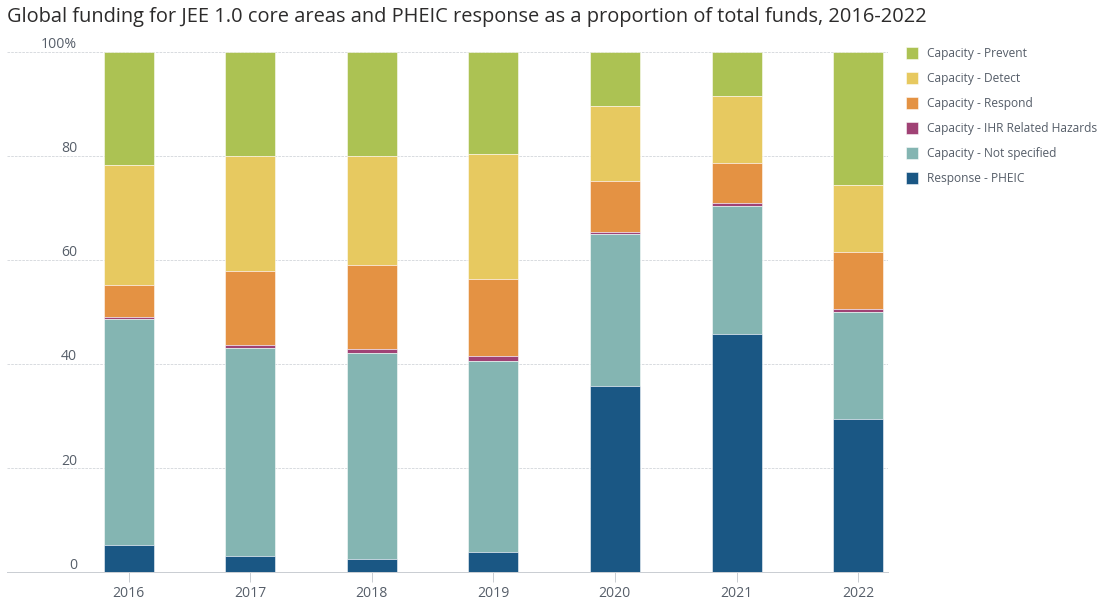

In [375]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Define variables
x=pivot_df['Date']
y1=percentage_prevent
y2=percentage_detect
y3=percentage_respond
y4=percentage_ihr
y5=percentage_unknown
y6 = percentage_response


# Plot bars
# The thing that gets plotted last in this list gets plotted on the bottom
bar_width = 150
plt.bar(x, y1, bottom=y6+y5+y4+y3+y2, linewidth=0.5, width=bar_width, align="center", color=colors[4], label='Capacity - Prevent')
plt.bar(x, y2, bottom=y6+y5+y4+y3, linewidth=0.5, width=bar_width, align="center", color=colors[5], label='Capacity - Detect')
plt.bar(x, y3, bottom=y6+y5+y4, linewidth=0.5, width=bar_width, align="center", color=colors[6], label='Capacity - Respond')
plt.bar(x, y4, bottom=y6+y5, linewidth=0.5, width=bar_width, align="center", color=colors[8], label='Capacity - IHR Related Hazards')
plt.bar(x, y5, bottom=y6, linewidth=0.5, width=bar_width, align="center", color=colors[2], label='Capacity - Not specified')
plt.bar(x, y6, bottom=0, linewidth=0.5, width=bar_width, align="center", color=colors[0], label='Response - PHEIC')



# ax.xaxis_date()

# Define x-axis range
left = dt.date(2015,1,1)
right = dt.date(2022,4,1)

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,100)

# Set title
title = "Global funding for JEE 1.0 core areas and PHEIC response as a proportion of total funds, 2016-2022"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['{:,.0f}%'.format(y) if i == 5 else '{:,.0f}'.format(y) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-70) 

# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.25,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

plt.tight_layout(pad = 1.5)
plt.show()
# plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/global_capacity_and_response_relative_2016-22.png', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait')

## 2. Who was funded for what?
- 2016-2022
- WHO Region recipients
- Core capacity funding 

### Cleaning

In [450]:
# Load data
raw = pd.read_csv('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/analyses/Core capacity recipients by WHO region/results/Core capacity recipients by WHO region by year__latest.csv')

# Clean data, converting year from numeric to datetime, and dropping the calculated columns
raw['Year'] = pd.to_datetime(raw['Year'], format='%Y').dt.year
raw['Date'] = pd.to_datetime(raw['Year'].astype(str) + '-01-01')

# Filter the DataFrame to only include rows in 2016-2022 range
df = raw[raw['Year'] >= 2016]
df = df[df['Year'] <= 2022]

df.head()


,Recipient WHO Region,Core capacity,Core capacity code,Total disbursed (nominal USD),Year,Date
1387,searo,Unspecified,Unspecified,7.805072e+08,2016,2016-01-01
1388,searo,Biosafety and Biosecurity,P.6,4.929424e+07,2016,2016-01-01
1389,NaN,Medical Countermeasures and Personnel Deployment,R.4,5.048242e+07,2016,2016-01-01
1390,amro,Real Time Surveillance,D.2,3.586856e+07,2016,2016-01-01
1391,wpro,Immunization,P.7,6.922977e+07,2016,2016-01-01


In [451]:
afro = df[df['Recipient WHO Region'] == 'afro']
amro = df[df['Recipient WHO Region'] == 'amro']
emro = df[df['Recipient WHO Region'] == 'emro']
euro = df[df['Recipient WHO Region'] == 'euro']
searo = df[df['Recipient WHO Region'] == 'searo']
wpro = df[df['Recipient WHO Region'] == 'wpro']

### AFRO

In [453]:
# Pivot the DataFrame with species as columns
afro_df = afro.pivot_table(index='Date', columns='Core capacity code', values='Total disbursed (nominal USD)', aggfunc = 'sum',fill_value=0)

# Flatten the DataFrame
afro_df.reset_index(inplace=True)

# Calculate total for each row
afro_df['Total'] = afro_df.sum(axis=1)

afro_df['Prevent'] = afro_df['P.1'] + afro_df['P.2'] + afro_df['P.3'] + afro_df['P.4'] + afro_df['P.5'] + afro_df['P.6'] + afro_df['P.7']
afro_df['Detect'] = afro_df['D.1'] + afro_df['D.2'] + afro_df['D.3'] + afro_df['D.4']
afro_df['Respond'] = afro_df['R.1'] + afro_df['R.2'] + afro_df['R.3'] + afro_df['R.4'] + afro_df['R.5'] 
afro_df['IHR Related Hazards'] = afro_df['CE'] + afro_df['RE'] + afro_df['PoE']
afro_df['Not specified'] = afro_df['General IHR'] + afro_df['Unspecified']

afro_df

Core capacity code,Date,CE,D.1,D.2,D.3,D.4,General IHR,P.1,P.2,P.3,...,R.4,R.5,RE,Unspecified,Total,Prevent,Detect,Respond,IHR Related Hazards,Not specified
0,2016-01-01,2.837762e+06,7.054803e+08,8.603980e+08,1.211593e+09,9.132864e+08,5387.205408,6.244020e+08,0.000000,7.971098e+07,...,1.468265e+08,7.590315e+07,2.916790e+06,4.120662e+09,1.109206e+10,2.550513e+09,3.690757e+09,6.666667e+08,6.345756e+07,4.120668e+09
1,2017-01-01,0.000000e+00,9.282148e+08,9.210305e+08,1.461010e+09,1.163403e+09,5396.896800,5.706353e+08,0.000000,1.404032e+08,...,2.995128e+08,8.063012e+07,0.000000e+00,4.524386e+09,1.293212e+10,2.759498e+09,4.473658e+09,1.071692e+09,1.028765e+08,4.524391e+09
2,2018-01-01,6.955818e+05,6.882018e+08,1.021762e+09,1.316433e+09,1.081709e+09,5515.339536,4.452380e+08,0.000000,1.166664e+08,...,3.038935e+08,1.103593e+08,6.955818e+05,4.262631e+09,1.208558e+10,2.444769e+09,4.108106e+09,1.166426e+09,1.036403e+08,4.262636e+09
3,2019-01-01,0.000000e+00,1.523483e+09,1.359392e+09,1.925634e+09,2.037096e+09,0.000000,9.308750e+08,0.000000,1.696690e+08,...,8.985813e+08,9.894244e+07,0.000000e+00,5.938031e+09,1.802717e+10,3.044633e+09,6.845606e+09,2.036879e+09,1.620248e+08,5.938031e+09
4,2020-01-01,2.168212e+05,1.707783e+09,1.603544e+09,1.811659e+09,1.750430e+09,0.000000,7.672586e+08,0.000000,2.341378e+08,...,7.807288e+08,1.046410e+08,1.262759e+06,6.591619e+09,1.872553e+10,2.751128e+09,6.873415e+09,2.324640e+09,1.847259e+08,6.591619e+09
5,2021-01-01,0.000000e+00,1.786613e+09,1.824092e+09,1.707935e+09,1.580234e+09,0.000000,6.193973e+08,94895.900466,3.307278e+08,...,5.847293e+08,1.285594e+08,2.283380e+06,7.273206e+09,1.924059e+10,2.769296e+09,6.898874e+09,2.077493e+09,2.217222e+08,7.273206e+09
6,2022-01-01,0.000000e+00,3.660122e+08,5.720370e+08,4.306501e+08,1.152756e+08,0.000000,2.026234e+08,0.000000,8.964083e+07,...,2.945634e+07,4.115526e+07,7.273550e+05,1.644275e+09,4.344494e+09,9.689490e+08,1.483975e+09,2.252700e+08,2.202469e+07,1.644275e+09


### Stacked bar chart

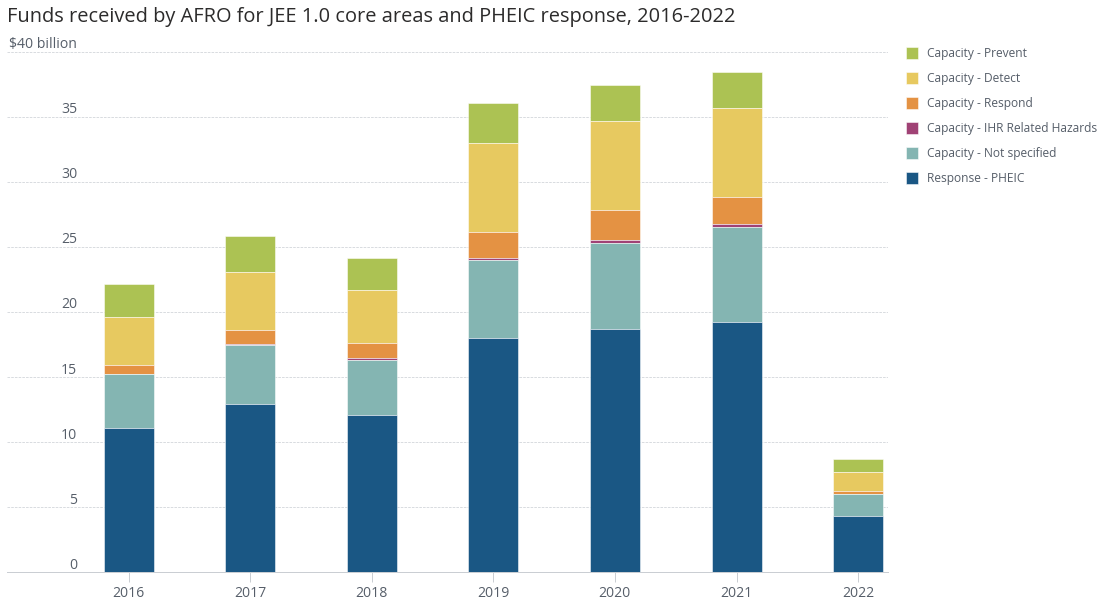

In [458]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Define variables
x=afro_df['Date']
y1=afro_df['Prevent'] 
y2=afro_df['Detect']
y3=afro_df['Respond']
y4=afro_df['IHR Related Hazards']
y5=afro_df['Not specified']
y6 = afro_df['Total']


# Plot bars
# The thing that gets plotted last in this list gets plotted on the bottom
bar_width = 150
plt.bar(x, y1, bottom=y6+y5+y4+y3+y2, linewidth=0.5, width=bar_width, align="center", color=colors[4], label='Capacity - Prevent')
plt.bar(x, y2, bottom=y6+y5+y4+y3, linewidth=0.5, width=bar_width, align="center", color=colors[5], label='Capacity - Detect')
plt.bar(x, y3, bottom=y6+y5+y4, linewidth=0.5, width=bar_width, align="center", color=colors[6], label='Capacity - Respond')
plt.bar(x, y4, bottom=y6+y5, linewidth=0.5, width=bar_width, align="center", color=colors[8], label='Capacity - IHR Related Hazards')
plt.bar(x, y5, bottom=y6, linewidth=0.5, width=bar_width, align="center", color=colors[2], label='Capacity - Not specified')
plt.bar(x, y6, bottom=0, linewidth=0.5, width=bar_width, align="center", color=colors[0], label='Response - PHEIC')



# ax.xaxis_date()

# Define x-axis range
left = dt.date(2015,1,1)
right = dt.date(2022,4,1)

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,40e9)

# Set title
title = "Funds received by AFRO for JEE 1.0 core areas and PHEIC response, 2016-2022"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['${:,.0f} billion'.format(y / 1e9) if i == 8 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-70) 

# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.25,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

plt.tight_layout(pad = 1.5)
# plt.show()
plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/afro_recipient_capacity_and_response_2016-22.png', dpi=1200, facecolor='w', 
            edgecolor='w', 
            orientation='portrait')

### Area chart

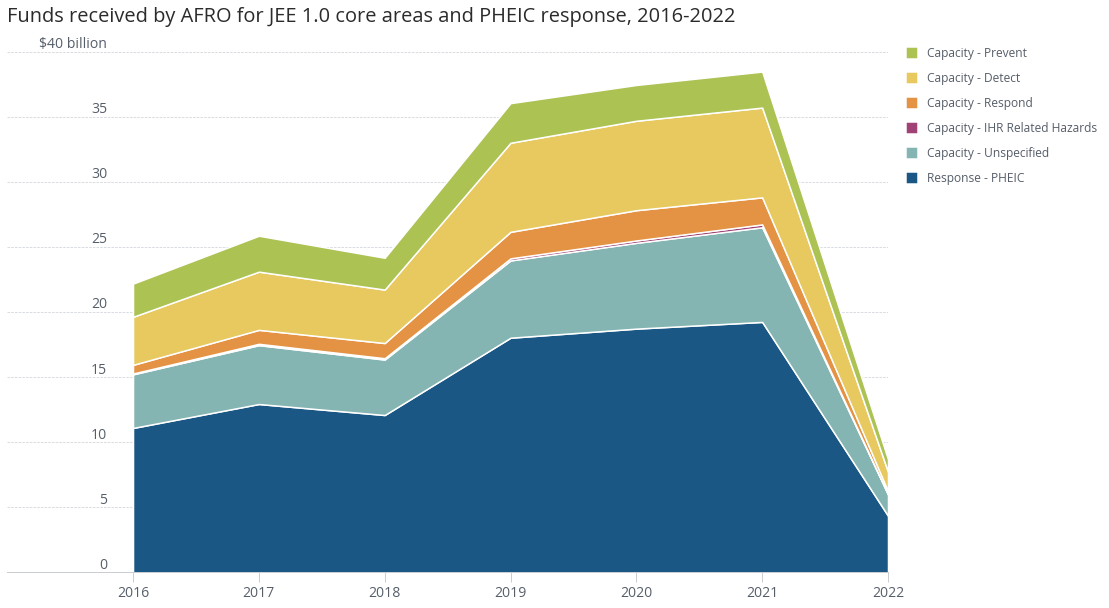

In [460]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Combine y-values into a list of lists
reversed_y_values = [y6, y5, y4, y3, y2, y1]


x = [2016, 2017, 2018, 2019, 2020, 2021, 2022]

labels = ['Capacity - Prevent','Capacity - Detect','Capacity - Respond','Capacity - IHR Related Hazards','Capacity - Unspecified', 'Response - PHEIC']

# Stackplot using x and y_values
plt.stackplot(x, reversed_y_values, colors = [colors[0],colors[2],colors[8],colors[6],colors[5],colors[4]], labels=labels)

# Define x-axis range
left = 2015
right = 2022

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,40e9)

# Set title
title = "Funds received by AFRO for JEE 1.0 core areas and PHEIC response, 2016-2022"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['${:,.0f} billion'.format(y / 1e9) if i == 8 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-100) 

# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
handles.reverse()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.25,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

plt.tight_layout(pad=1.5)
plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/afro_recipient_core_capacity_pheic_area_2016-22.png', dpi=1200, facecolor='w', 
            edgecolor='w', 
            orientation='portrait')

### AMRO

In [478]:
# Pivot the DataFrame with species as columns
amro_df = amro.pivot_table(index='Date', columns='Core capacity code', values='Total disbursed (nominal USD)', aggfunc = 'sum',fill_value=0)

# Flatten the DataFrame
amro_df.reset_index(inplace=True)

# Calculate total for each row
amro_df['Total'] = amro_df.sum(axis=1)

amro_df['Prevent'] = amro_df['P.1'] + amro_df['P.3'] + amro_df['P.4'] + amro_df['P.5'] + amro_df['P.6'] + amro_df['P.7']
amro_df['Detect'] = amro_df['D.1'] + amro_df['D.2'] + amro_df['D.3'] + amro_df['D.4']
amro_df['Respond'] = amro_df['R.1'] + amro_df['R.2'] + amro_df['R.3'] + amro_df['R.4'] + amro_df['R.5'] 
amro_df['IHR Related Hazards'] = amro_df['RE'] + amro_df['PoE']
amro_df['Not specified'] = amro_df['Unspecified']


### Stacked bar chart

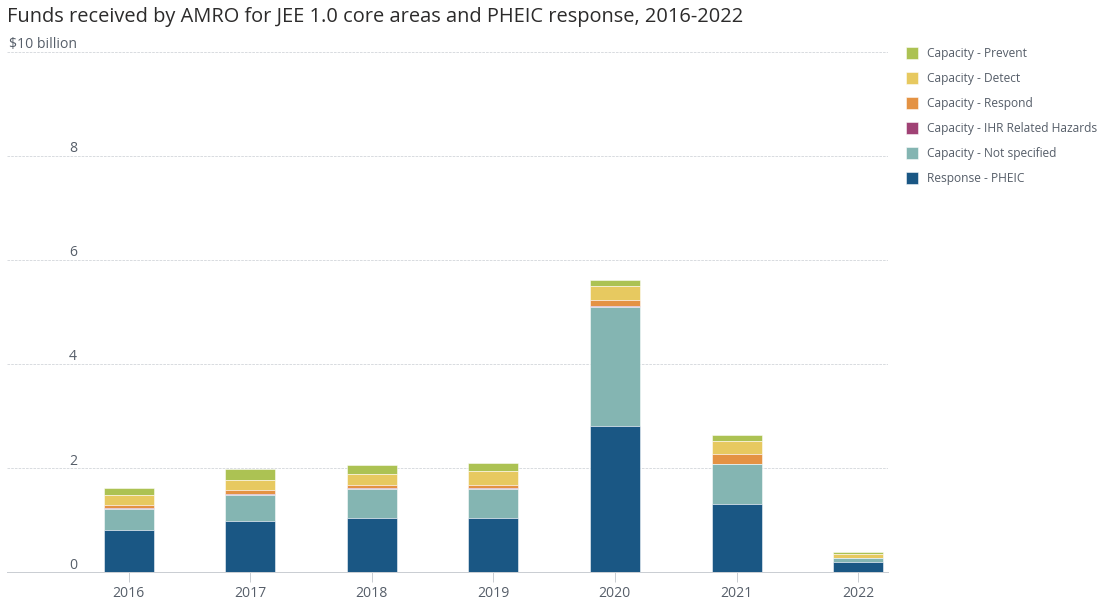

In [484]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Define variables
x=amro_df['Date']
y1=amro_df['Prevent'] 
y2=amro_df['Detect']
y3=amro_df['Respond']
y4=amro_df['IHR Related Hazards']
y5=amro_df['Not specified']
y6 = amro_df['Total']


# Plot bars
# The thing that gets plotted last in this list gets plotted on the bottom
bar_width = 150
plt.bar(x, y1, bottom=y6+y5+y4+y3+y2, linewidth=0.5, width=bar_width, align="center", color=colors[4], label='Capacity - Prevent')
plt.bar(x, y2, bottom=y6+y5+y4+y3, linewidth=0.5, width=bar_width, align="center", color=colors[5], label='Capacity - Detect')
plt.bar(x, y3, bottom=y6+y5+y4, linewidth=0.5, width=bar_width, align="center", color=colors[6], label='Capacity - Respond')
plt.bar(x, y4, bottom=y6+y5, linewidth=0.5, width=bar_width, align="center", color=colors[8], label='Capacity - IHR Related Hazards')
plt.bar(x, y5, bottom=y6, linewidth=0.5, width=bar_width, align="center", color=colors[2], label='Capacity - Not specified')
plt.bar(x, y6, bottom=0, linewidth=0.5, width=bar_width, align="center", color=colors[0], label='Response - PHEIC')



# ax.xaxis_date()

# Define x-axis range
left = dt.date(2015,1,1)
right = dt.date(2022,4,1)

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,10e9)

# Set title
title = "Funds received by AMRO for JEE 1.0 core areas and PHEIC response, 2016-2022"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['${:,.0f} billion'.format(y / 1e9) if i == 5 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-70) 

# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.25,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

plt.tight_layout(pad = 1.5)
# plt.show()
plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/amro_recipient_capacity_and_response_2016-22.png', dpi=1200, facecolor='w', 
            edgecolor='w', 
            orientation='portrait')

### Area chart

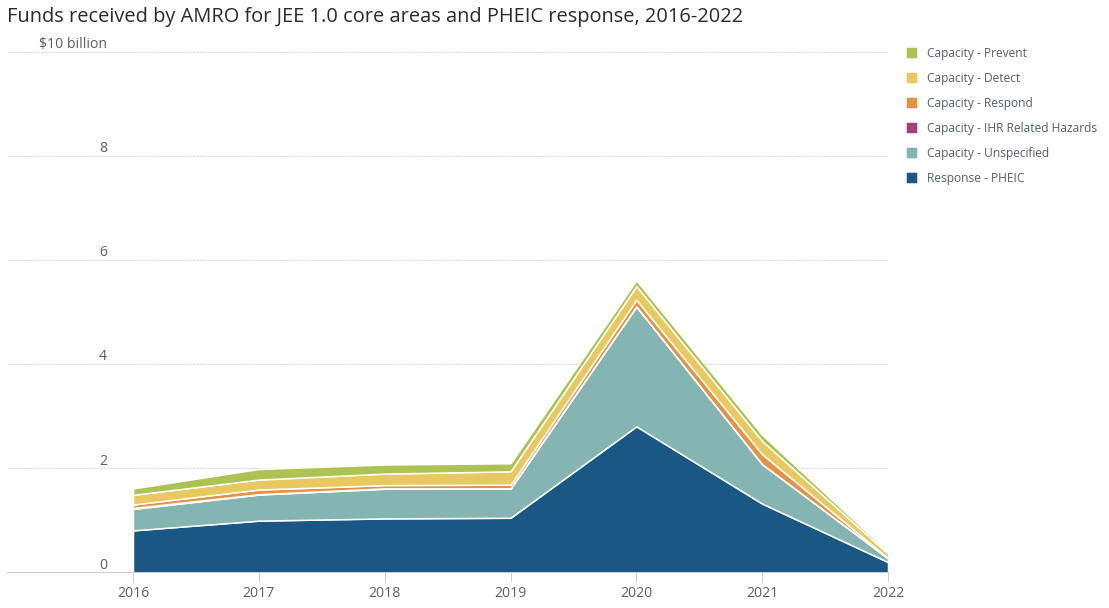

In [485]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Combine y-values into a list of lists
reversed_y_values = [y6, y5, y4, y3, y2, y1]


x = [2016, 2017, 2018, 2019, 2020, 2021, 2022]

labels = ['Capacity - Prevent','Capacity - Detect','Capacity - Respond','Capacity - IHR Related Hazards','Capacity - Unspecified', 'Response - PHEIC']

# Stackplot using x and y_values
plt.stackplot(x, reversed_y_values, colors = [colors[0],colors[2],colors[8],colors[6],colors[5],colors[4]], labels=labels)

# Define x-axis range
left = 2015
right = 2022

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,10e9)

# Set title
title = "Funds received by AMRO for JEE 1.0 core areas and PHEIC response, 2016-2022"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['${:,.0f} billion'.format(y / 1e9) if i == 5 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-100) 

# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
handles.reverse()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.25,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

plt.tight_layout(pad=1.5)
plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/amro_recipient_core_capacity_pheic_area_2016-22.png', dpi=1200, facecolor='w', 
            edgecolor='w', 
            orientation='portrait')

### EMRO

In [486]:
# Pivot the DataFrame with species as columns
emro_df = emro.pivot_table(index='Date', columns='Core capacity code', values='Total disbursed (nominal USD)', aggfunc = 'sum',fill_value=0)

# Flatten the DataFrame
emro_df.reset_index(inplace=True)

# Calculate total for each row
emro_df['Total'] = emro_df.sum(axis=1)

emro_df['Prevent'] = emro_df['P.1'] + emro_df['P.3'] + emro_df['P.4'] + emro_df['P.5'] + emro_df['P.6'] + emro_df['P.7']
emro_df['Detect'] = emro_df['D.1'] + emro_df['D.2'] + emro_df['D.3'] + emro_df['D.4']
emro_df['Respond'] = emro_df['R.1'] + emro_df['R.2'] + emro_df['R.3'] + emro_df['R.4'] + emro_df['R.5'] 
emro_df['IHR Related Hazards'] = emro_df['CE'] + emro_df['RE'] + emro_df['PoE']
emro_df['Not specified'] = emro_df['Unspecified']

### Stacked bar chart

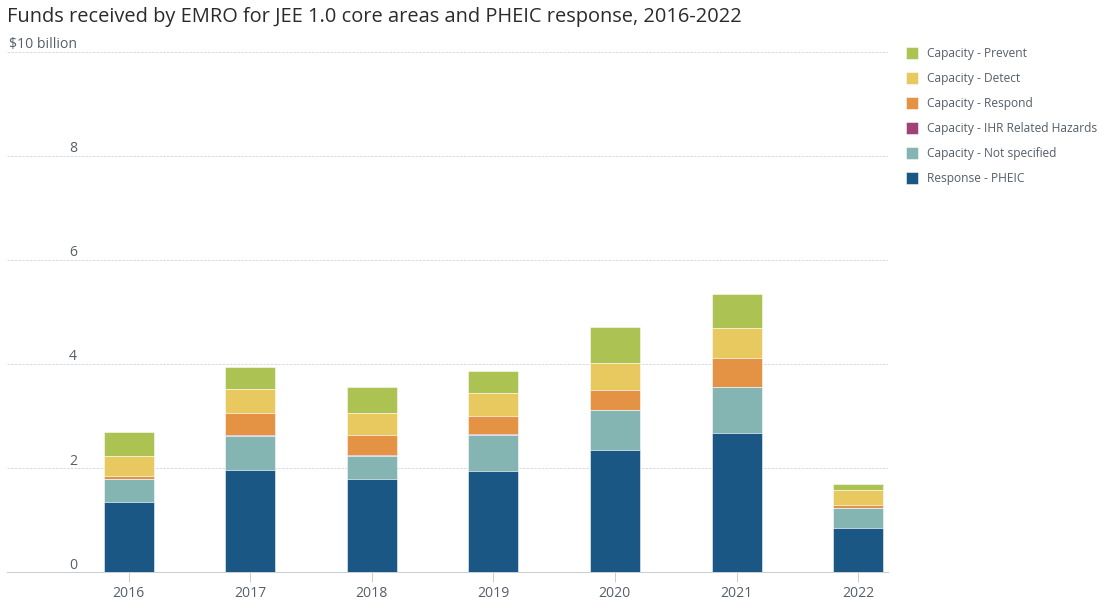

In [488]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Define variables
x=emro_df['Date']
y1=emro_df['Prevent'] 
y2=emro_df['Detect']
y3=emro_df['Respond']
y4=emro_df['IHR Related Hazards']
y5=emro_df['Not specified']
y6 = emro_df['Total']


# Plot bars
# The thing that gets plotted last in this list gets plotted on the bottom
bar_width = 150
plt.bar(x, y1, bottom=y6+y5+y4+y3+y2, linewidth=0.5, width=bar_width, align="center", color=colors[4], label='Capacity - Prevent')
plt.bar(x, y2, bottom=y6+y5+y4+y3, linewidth=0.5, width=bar_width, align="center", color=colors[5], label='Capacity - Detect')
plt.bar(x, y3, bottom=y6+y5+y4, linewidth=0.5, width=bar_width, align="center", color=colors[6], label='Capacity - Respond')
plt.bar(x, y4, bottom=y6+y5, linewidth=0.5, width=bar_width, align="center", color=colors[8], label='Capacity - IHR Related Hazards')
plt.bar(x, y5, bottom=y6, linewidth=0.5, width=bar_width, align="center", color=colors[2], label='Capacity - Not specified')
plt.bar(x, y6, bottom=0, linewidth=0.5, width=bar_width, align="center", color=colors[0], label='Response - PHEIC')



# ax.xaxis_date()

# Define x-axis range
left = dt.date(2015,1,1)
right = dt.date(2022,4,1)

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,10e9)

# Set title
title = "Funds received by EMRO for JEE 1.0 core areas and PHEIC response, 2016-2022"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['${:,.0f} billion'.format(y / 1e9) if i == 5 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-70) 

# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.25,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

plt.tight_layout(pad = 1.5)
# plt.show()
plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/emro_recipient_capacity_and_response_2016-22.png', dpi=1200, facecolor='w', 
            edgecolor='w', 
            orientation='portrait')

### Area chart

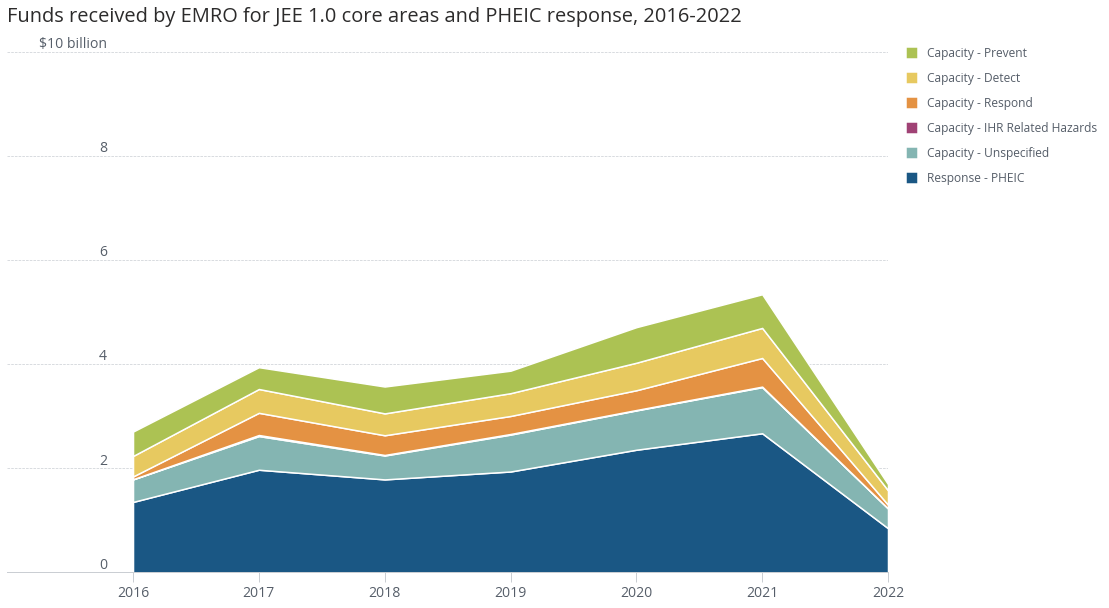

In [489]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Combine y-values into a list of lists
reversed_y_values = [y6, y5, y4, y3, y2, y1]


x = [2016, 2017, 2018, 2019, 2020, 2021, 2022]

labels = ['Capacity - Prevent','Capacity - Detect','Capacity - Respond','Capacity - IHR Related Hazards','Capacity - Unspecified', 'Response - PHEIC']

# Stackplot using x and y_values
plt.stackplot(x, reversed_y_values, colors = [colors[0],colors[2],colors[8],colors[6],colors[5],colors[4]], labels=labels)

# Define x-axis range
left = 2015
right = 2022

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,10e9)

# Set title
title = "Funds received by EMRO for JEE 1.0 core areas and PHEIC response, 2016-2022"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['${:,.0f} billion'.format(y / 1e9) if i == 5 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-100) 

# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
handles.reverse()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.25,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

plt.tight_layout(pad=1.5)
plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/emro_recipient_core_capacity_pheic_area_2016-22.png', dpi=1200, facecolor='w', 
            edgecolor='w', 
            orientation='portrait')

### EURO

In [490]:
# Pivot the DataFrame with species as columns
euro_df = euro.pivot_table(index='Date', columns='Core capacity code', values='Total disbursed (nominal USD)', aggfunc = 'sum',fill_value=0)

# Flatten the DataFrame
euro_df.reset_index(inplace=True)

# Calculate total for each row
euro_df['Total'] = euro_df.sum(axis=1)


euro_df['Prevent'] = euro_df['P.1'] +  euro_df['P.3'] + euro_df['P.4'] + euro_df['P.5'] + euro_df['P.6'] + euro_df['P.7']
euro_df['Detect'] = euro_df['D.1'] + euro_df['D.2'] + euro_df['D.3'] + euro_df['D.4']
euro_df['Respond'] = euro_df['R.1'] + euro_df['R.2'] + euro_df['R.3'] + euro_df['R.4'] + euro_df['R.5'] 
euro_df['IHR Related Hazards'] = euro_df['CE'] + euro_df['RE'] + euro_df['PoE']
euro_df['Not specified'] = euro_df['Unspecified']


### Stacked bar chart

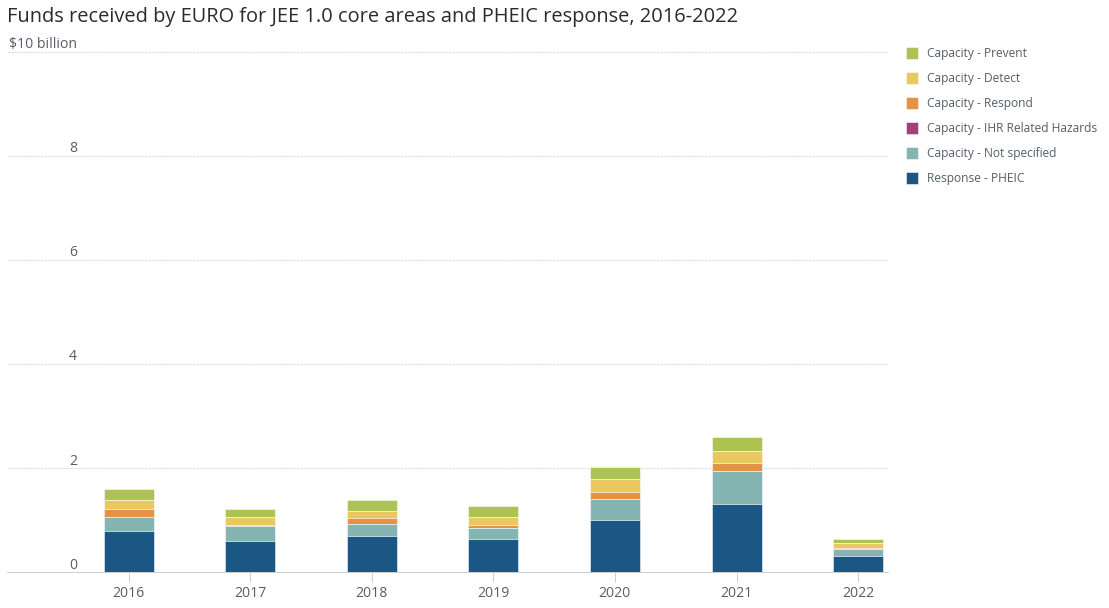

In [492]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Define variables
x=euro_df['Date']
y1=euro_df['Prevent'] 
y2=euro_df['Detect']
y3=euro_df['Respond']
y4=euro_df['IHR Related Hazards']
y5=euro_df['Not specified']
y6 = euro_df['Total']


# Plot bars
# The thing that gets plotted last in this list gets plotted on the bottom
bar_width = 150
plt.bar(x, y1, bottom=y6+y5+y4+y3+y2, linewidth=0.5, width=bar_width, align="center", color=colors[4], label='Capacity - Prevent')
plt.bar(x, y2, bottom=y6+y5+y4+y3, linewidth=0.5, width=bar_width, align="center", color=colors[5], label='Capacity - Detect')
plt.bar(x, y3, bottom=y6+y5+y4, linewidth=0.5, width=bar_width, align="center", color=colors[6], label='Capacity - Respond')
plt.bar(x, y4, bottom=y6+y5, linewidth=0.5, width=bar_width, align="center", color=colors[8], label='Capacity - IHR Related Hazards')
plt.bar(x, y5, bottom=y6, linewidth=0.5, width=bar_width, align="center", color=colors[2], label='Capacity - Not specified')
plt.bar(x, y6, bottom=0, linewidth=0.5, width=bar_width, align="center", color=colors[0], label='Response - PHEIC')



# ax.xaxis_date()

# Define x-axis range
left = dt.date(2015,1,1)
right = dt.date(2022,4,1)

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,10e9)

# Set title
title = "Funds received by EURO for JEE 1.0 core areas and PHEIC response, 2016-2022"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['${:,.0f} billion'.format(y / 1e9) if i == 5 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-70) 

# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.25,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

plt.tight_layout(pad = 1.5)
# plt.show()
plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/euro_recipient_capacity_and_response_2016-22.png', dpi=1200, facecolor='w', 
            edgecolor='w', 
            orientation='portrait')

### Area chart

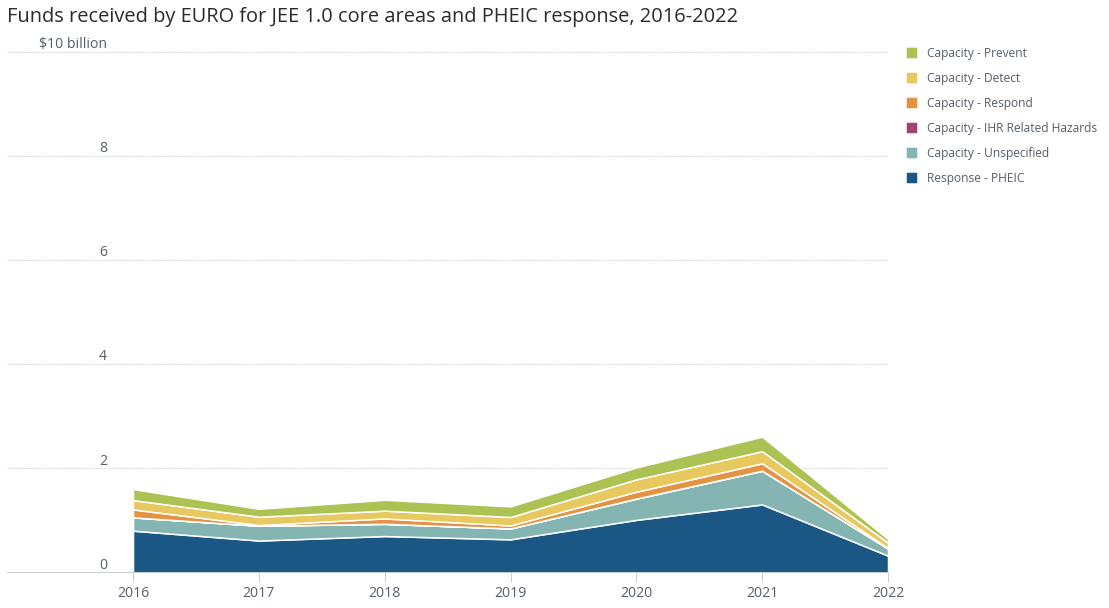

In [493]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Combine y-values into a list of lists
reversed_y_values = [y6, y5, y4, y3, y2, y1]


x = [2016, 2017, 2018, 2019, 2020, 2021, 2022]

labels = ['Capacity - Prevent','Capacity - Detect','Capacity - Respond','Capacity - IHR Related Hazards','Capacity - Unspecified', 'Response - PHEIC']

# Stackplot using x and y_values
plt.stackplot(x, reversed_y_values, colors = [colors[0],colors[2],colors[8],colors[6],colors[5],colors[4]], labels=labels)

# Define x-axis range
left = 2015
right = 2022

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,10e9)

# Set title
title = "Funds received by EURO for JEE 1.0 core areas and PHEIC response, 2016-2022"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['${:,.0f} billion'.format(y / 1e9) if i == 5 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-100) 

# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
handles.reverse()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.25,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

plt.tight_layout(pad=1.5)
plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/euro_recipient_core_capacity_pheic_area_2016-22.png', dpi=1200, facecolor='w', 
            edgecolor='w', 
            orientation='portrait')

### SEARO

In [494]:
# Pivot the DataFrame with species as columns
searo_df = searo.pivot_table(index='Date', columns='Core capacity code', values='Total disbursed (nominal USD)', aggfunc = 'sum',fill_value=0)

# Flatten the DataFrame
searo_df.reset_index(inplace=True)

# Calculate total for each row
searo_df['Total'] = searo_df.sum(axis=1)

searo_df['Prevent'] = searo_df['P.1'] + searo_df['P.3'] + searo_df['P.4'] + searo_df['P.5'] + searo_df['P.6'] + searo_df['P.7']
searo_df['Detect'] = searo_df['D.1'] + searo_df['D.2'] + searo_df['D.3'] + searo_df['D.4']
searo_df['Respond'] = searo_df['R.1'] + searo_df['R.2'] + searo_df['R.3'] + searo_df['R.4'] + searo_df['R.5'] 
searo_df['IHR Related Hazards'] = searo_df['RE'] + searo_df['PoE']
searo_df['Not specified'] =  searo_df['Unspecified']

### Stacked bar chart

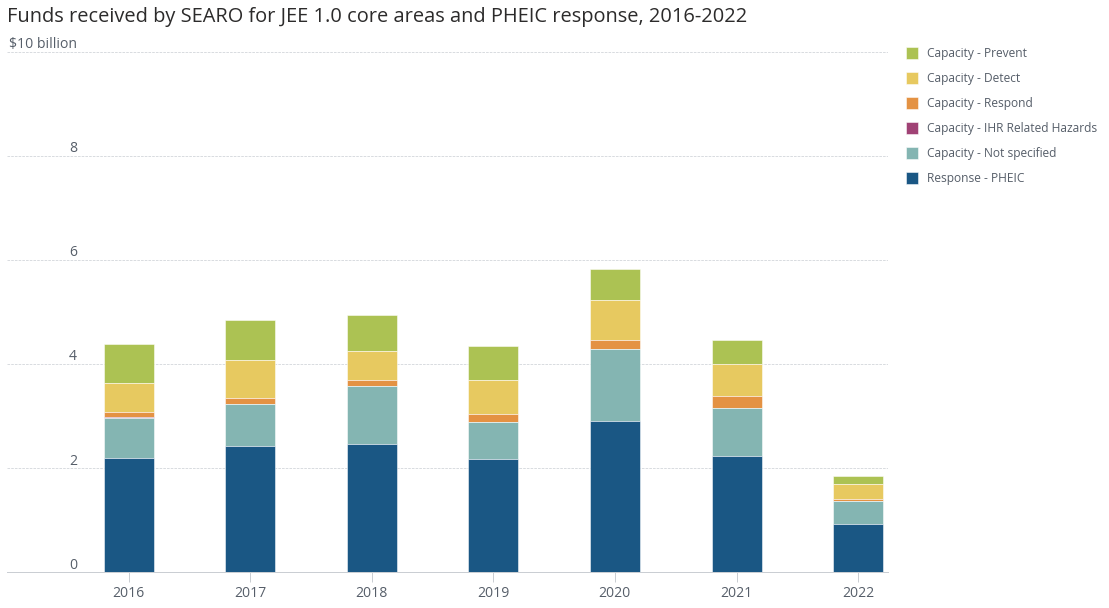

In [496]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Define variables
x=searo_df['Date']
y1=searo_df['Prevent'] 
y2=searo_df['Detect']
y3=searo_df['Respond']
y4=searo_df['IHR Related Hazards']
y5=searo_df['Not specified']
y6 = searo_df['Total']


# Plot bars
# The thing that gets plotted last in this list gets plotted on the bottom
bar_width = 150
plt.bar(x, y1, bottom=y6+y5+y4+y3+y2, linewidth=0.5, width=bar_width, align="center", color=colors[4], label='Capacity - Prevent')
plt.bar(x, y2, bottom=y6+y5+y4+y3, linewidth=0.5, width=bar_width, align="center", color=colors[5], label='Capacity - Detect')
plt.bar(x, y3, bottom=y6+y5+y4, linewidth=0.5, width=bar_width, align="center", color=colors[6], label='Capacity - Respond')
plt.bar(x, y4, bottom=y6+y5, linewidth=0.5, width=bar_width, align="center", color=colors[8], label='Capacity - IHR Related Hazards')
plt.bar(x, y5, bottom=y6, linewidth=0.5, width=bar_width, align="center", color=colors[2], label='Capacity - Not specified')
plt.bar(x, y6, bottom=0, linewidth=0.5, width=bar_width, align="center", color=colors[0], label='Response - PHEIC')



# ax.xaxis_date()

# Define x-axis range
left = dt.date(2015,1,1)
right = dt.date(2022,4,1)

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,10e9)

# Set title
title = "Funds received by SEARO for JEE 1.0 core areas and PHEIC response, 2016-2022"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['${:,.0f} billion'.format(y / 1e9) if i == 5 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-70) 

# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.25,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

plt.tight_layout(pad = 1.5)
# plt.show()
plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/searo_recipient_capacity_and_response_2016-22.png', dpi=1200, facecolor='w', 
            edgecolor='w', 
            orientation='portrait')

### Area chart

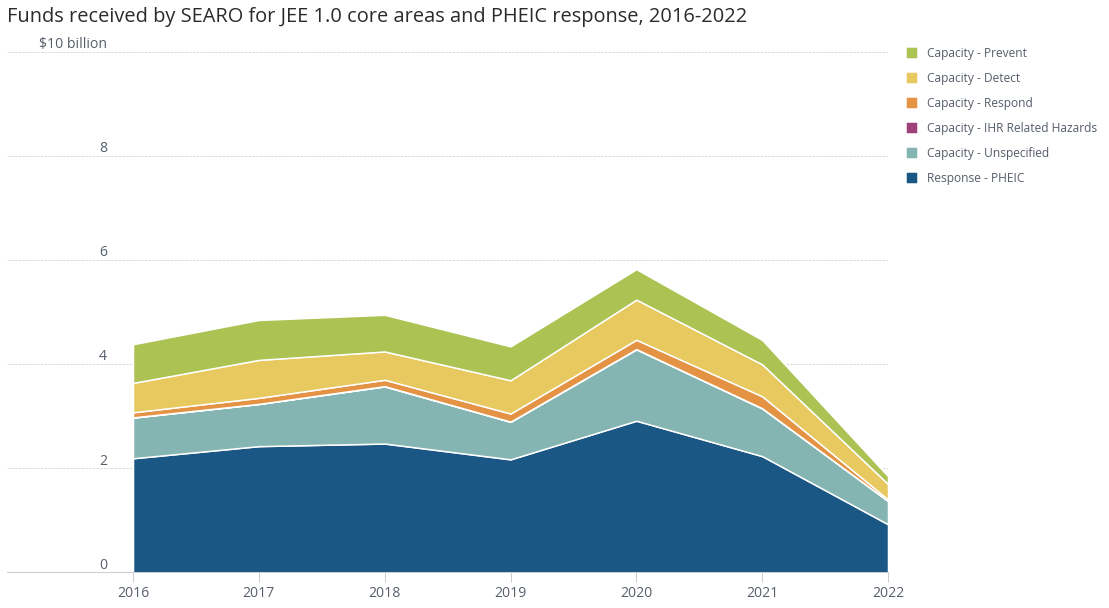

In [497]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Combine y-values into a list of lists
reversed_y_values = [y6, y5, y4, y3, y2, y1]


x = [2016, 2017, 2018, 2019, 2020, 2021, 2022]

labels = ['Capacity - Prevent','Capacity - Detect','Capacity - Respond','Capacity - IHR Related Hazards','Capacity - Unspecified', 'Response - PHEIC']

# Stackplot using x and y_values
plt.stackplot(x, reversed_y_values, colors = [colors[0],colors[2],colors[8],colors[6],colors[5],colors[4]], labels=labels)

# Define x-axis range
left = 2015
right = 2022

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,10e9)

# Set title
title = "Funds received by SEARO for JEE 1.0 core areas and PHEIC response, 2016-2022"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['${:,.0f} billion'.format(y / 1e9) if i == 5 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-100) 

# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
handles.reverse()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.25,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

plt.tight_layout(pad=1.5)
plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/searo_recipient_core_capacity_pheic_area_2016-22.png', dpi=1200, facecolor='w', 
            edgecolor='w', 
            orientation='portrait')

### WPRO

In [498]:
# Pivot the DataFrame with species as columns
wpro_df = wpro.pivot_table(index='Date', columns='Core capacity code', values='Total disbursed (nominal USD)', aggfunc = 'sum',fill_value=0)

# Flatten the DataFrame
wpro_df.reset_index(inplace=True)

# Calculate total for each row
wpro_df['Total'] = wpro_df.sum(axis=1)

wpro_df['Prevent'] = wpro_df['P.1'] + wpro_df['P.3'] + wpro_df['P.4'] + wpro_df['P.5'] + wpro_df['P.6'] + wpro_df['P.7']
wpro_df['Detect'] = wpro_df['D.1'] + wpro_df['D.2'] + wpro_df['D.3'] + wpro_df['D.4']
wpro_df['Respond'] = wpro_df['R.1'] + wpro_df['R.2'] + wpro_df['R.3'] + wpro_df['R.4'] + wpro_df['R.5'] 
wpro_df['IHR Related Hazards'] =  wpro_df['RE'] + wpro_df['PoE']
wpro_df['Not specified'] =  wpro_df['Unspecified']

### Stacked bar chart

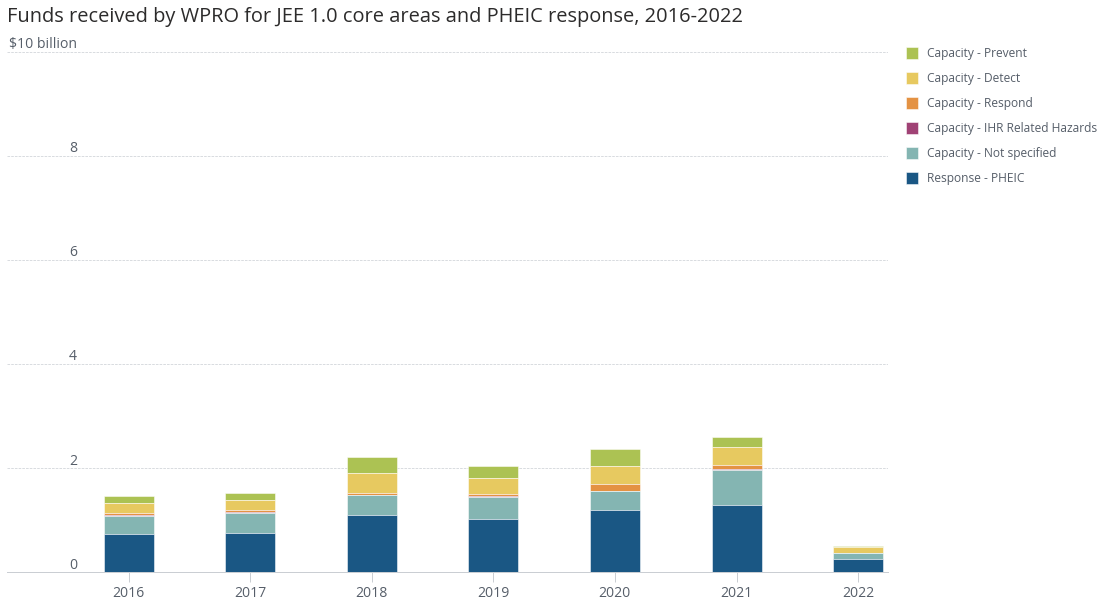

In [499]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Define variables
x=wpro_df['Date']
y1=wpro_df['Prevent'] 
y2=wpro_df['Detect']
y3=wpro_df['Respond']
y4=wpro_df['IHR Related Hazards']
y5=wpro_df['Not specified']
y6 = wpro_df['Total']


# Plot bars
# The thing that gets plotted last in this list gets plotted on the bottom
bar_width = 150
plt.bar(x, y1, bottom=y6+y5+y4+y3+y2, linewidth=0.5, width=bar_width, align="center", color=colors[4], label='Capacity - Prevent')
plt.bar(x, y2, bottom=y6+y5+y4+y3, linewidth=0.5, width=bar_width, align="center", color=colors[5], label='Capacity - Detect')
plt.bar(x, y3, bottom=y6+y5+y4, linewidth=0.5, width=bar_width, align="center", color=colors[6], label='Capacity - Respond')
plt.bar(x, y4, bottom=y6+y5, linewidth=0.5, width=bar_width, align="center", color=colors[8], label='Capacity - IHR Related Hazards')
plt.bar(x, y5, bottom=y6, linewidth=0.5, width=bar_width, align="center", color=colors[2], label='Capacity - Not specified')
plt.bar(x, y6, bottom=0, linewidth=0.5, width=bar_width, align="center", color=colors[0], label='Response - PHEIC')



# ax.xaxis_date()

# Define x-axis range
left = dt.date(2015,1,1)
right = dt.date(2022,4,1)

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,10e9)

# Set title
title = "Funds received by WPRO for JEE 1.0 core areas and PHEIC response, 2016-2022"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['${:,.0f} billion'.format(y / 1e9) if i == 5 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-70) 

# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.25,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

plt.tight_layout(pad = 1.5)
# plt.show()
plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/wpro_recipient_capacity_and_response_2016-22.png', dpi=1200, facecolor='w', 
            edgecolor='w', 
            orientation='portrait')

### Area chart

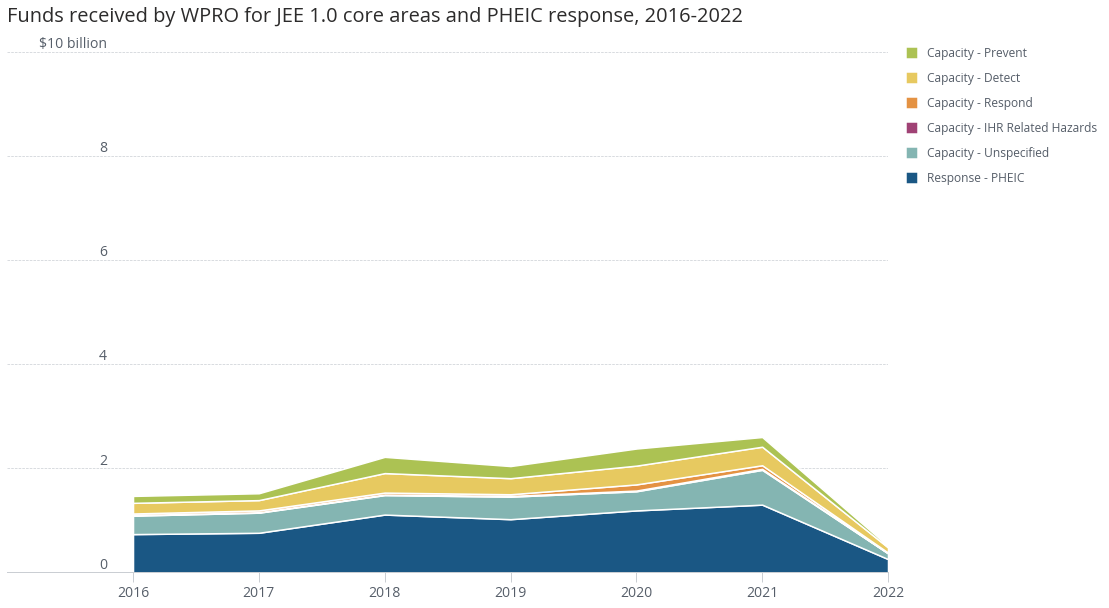

In [500]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Combine y-values into a list of lists
reversed_y_values = [y6, y5, y4, y3, y2, y1]


x = [2016, 2017, 2018, 2019, 2020, 2021, 2022]

labels = ['Capacity - Prevent','Capacity - Detect','Capacity - Respond','Capacity - IHR Related Hazards','Capacity - Unspecified', 'Response - PHEIC']

# Stackplot using x and y_values
plt.stackplot(x, reversed_y_values, colors = [colors[0],colors[2],colors[8],colors[6],colors[5],colors[4]], labels=labels)

# Define x-axis range
left = 2015
right = 2022

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,10e9)

# Set title
title = "Funds received by WPRO for JEE 1.0 core areas and PHEIC response, 2016-2022"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['${:,.0f} billion'.format(y / 1e9) if i == 5 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-100) 

# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
handles.reverse()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.25,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

plt.tight_layout(pad=1.5)
plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/wpro_recipient_core_capacity_pheic_area_2016-22.png', dpi=1200, facecolor='w', 
            edgecolor='w', 
            orientation='portrait')

### All regions, total funding
- 2016-2022
- Capacity and PHEIC response
- WHO region recipients only

### Stacked bar chart

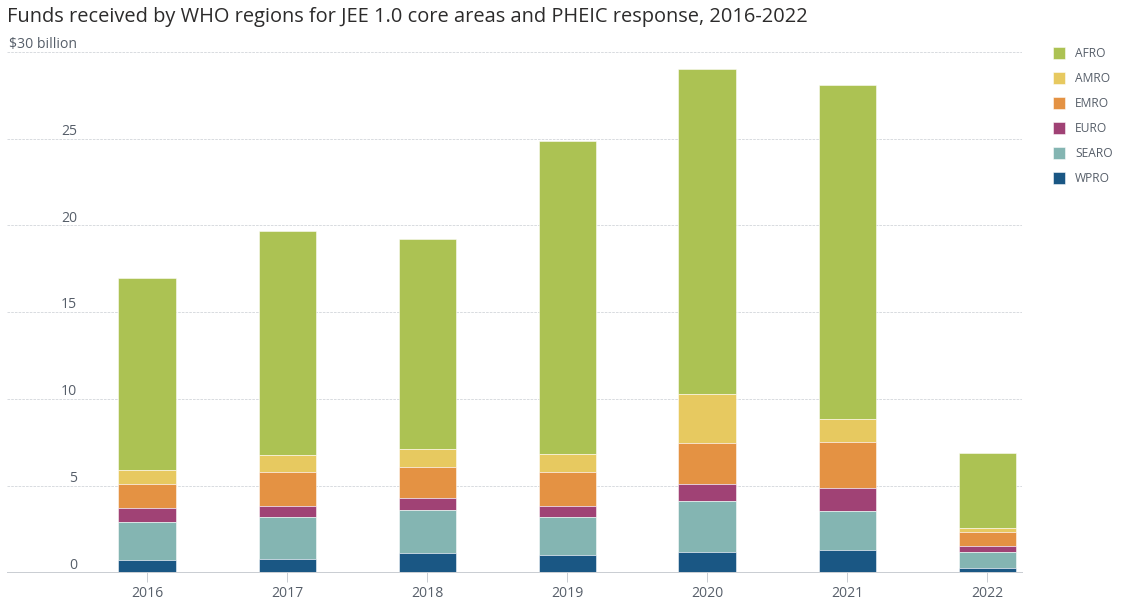

In [508]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Define variables
x=afro_df['Date']
y1=afro_df['Total'] 
y2=amro_df['Total']
y3=emro_df['Total']
y4=euro_df['Total']
y5=searo_df['Total']
y6 = wpro_df['Total']


# Plot bars
# The thing that gets plotted last in this list gets plotted on the bottom
bar_width = 150
plt.bar(x, y1, bottom=y6+y5+y4+y3+y2, linewidth=0.5, width=bar_width, align="center", color=colors[4], label='AFRO')
plt.bar(x, y2, bottom=y6+y5+y4+y3, linewidth=0.5, width=bar_width, align="center", color=colors[5], label='AMRO')
plt.bar(x, y3, bottom=y6+y5+y4, linewidth=0.5, width=bar_width, align="center", color=colors[6], label='EMRO')
plt.bar(x, y4, bottom=y6+y5, linewidth=0.5, width=bar_width, align="center", color=colors[8], label='EURO')
plt.bar(x, y5, bottom=y6, linewidth=0.5, width=bar_width, align="center", color=colors[2], label='SEARO')
plt.bar(x, y6, bottom=0, linewidth=0.5, width=bar_width, align="center", color=colors[0], label='WPRO')



# ax.xaxis_date()

# Define x-axis range
left = dt.date(2015,1,1)
right = dt.date(2022,4,1)

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,30e9)

# Set title
title = "Funds received by WHO regions for JEE 1.0 core areas and PHEIC response, 2016-2022"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['${:,.0f} billion'.format(y / 1e9) if i == 6 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-70) 

# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.1,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

plt.tight_layout(pad = 1.5)
# plt.show()
plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/all_who_recipient_capacity_and_response_2016-22.png', dpi=1200, facecolor='w', 
            edgecolor='w', 
            orientation='portrait')

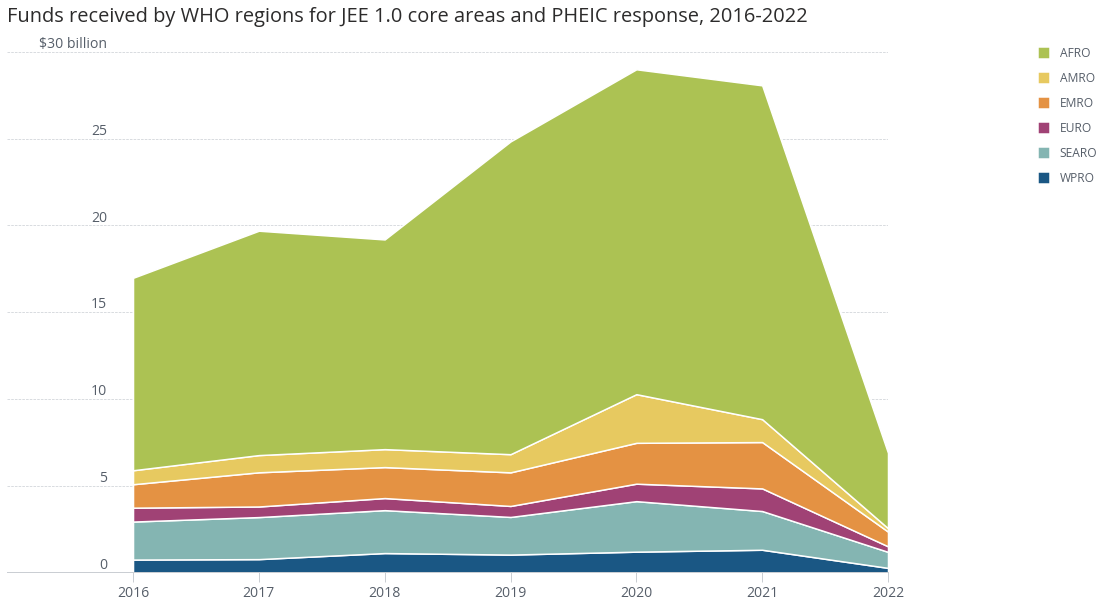

In [509]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Combine y-values into a list of lists
reversed_y_values = [y6, y5, y4, y3, y2, y1]


x = [2016, 2017, 2018, 2019, 2020, 2021, 2022]

labels = ['AFRO','AMRO','EMRO','EURO','SEARO', 'WPRO']

# Stackplot using x and y_values
plt.stackplot(x, reversed_y_values, colors = [colors[0],colors[2],colors[8],colors[6],colors[5],colors[4]], labels=labels)

# Define x-axis range
left = 2015
right = 2022

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,30e9)

# Set title
title = "Funds received by WHO regions for JEE 1.0 core areas and PHEIC response, 2016-2022"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['${:,.0f} billion'.format(y / 1e9) if i == 6 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-100) 

# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
handles.reverse()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.25,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

plt.tight_layout(pad=1.5)
plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/all_who_recipient_core_capacity_pheic_area_2016-22.png', dpi=1200, facecolor='w', 
            edgecolor='w', 
            orientation='portrait')

## 3. How many new players are entering the funding landscape?
- Number of unique relationships per year
- Capacity and response
- 2016-2022

### Cleaning

In [6]:
# Load data
raw = pd.read_csv('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/analyses/Flows by funder, core capacity, recipient, and year/results/Flows by funder, recipient, capacity, and year__latest.csv')

# Clean data, converting year from numeric to datetime, and dropping the calculated columns
raw['Year'] = pd.to_datetime(raw['Year'], format='%Y').dt.year
raw['Date'] = pd.to_datetime(raw['Year'].astype(str) + '-01-01')

# Filter the DataFrame to only include rows in 2016-2022 range
df = raw[raw['Year'] >= 2016]
df = df[df['Year'] <= 2022]

# Show data
df.head()

,Year,Funding type,Category,Core capacity,Funder Name,Funder Category,Funder Subcategory,Recipient Name,Recipient Category,Recipient Subcategory,Total Disbursed to Recipient,Date
0,2022,response,Unspecified,Unspecified,AICS - Agenzia Italiana per la Cooperazione al...,Country,agency,Jordan,Country,country,4052879.393,2022-01-01
1,2022,capacity,Respond,Preparedness,AICS - Agenzia Italiana per la Cooperazione al...,Country,agency,Middle East,Country,region,3956632.213,2022-01-01
2,2022,capacity,Detect,National Laboratory System,AICS - Agenzia Italiana per la Cooperazione al...,Country,agency,Burkina Faso,Country,country,1703291.129,2022-01-01
3,2022,capacity,Unspecified,Unspecified,AICS - Agenzia Italiana per la Cooperazione al...,Country,agency,Palestine,Country,country,1252813.146,2022-01-01
4,2022,capacity,Unspecified,Unspecified,AICS - Agenzia Italiana per la Cooperazione al...,Country,agency,Mozambique,Country,country,1247732.613,2022-01-01


### Bar chart

In [7]:
uq_relationships = df.groupby(['Date', 'Funder Name', 'Recipient Name']).size().reset_index(name='Relationship Count')

uq_relationships["Relationship Count"] = 1

uq_relationships = uq_relationships.groupby('Date').sum('Relationship Count').reset_index()

uq_relationships

,Date,Relationship Count
0,2016-01-01,2636
1,2017-01-01,2912
2,2018-01-01,3070
3,2019-01-01,3102
4,2020-01-01,4379
5,2021-01-01,3949
6,2022-01-01,2179


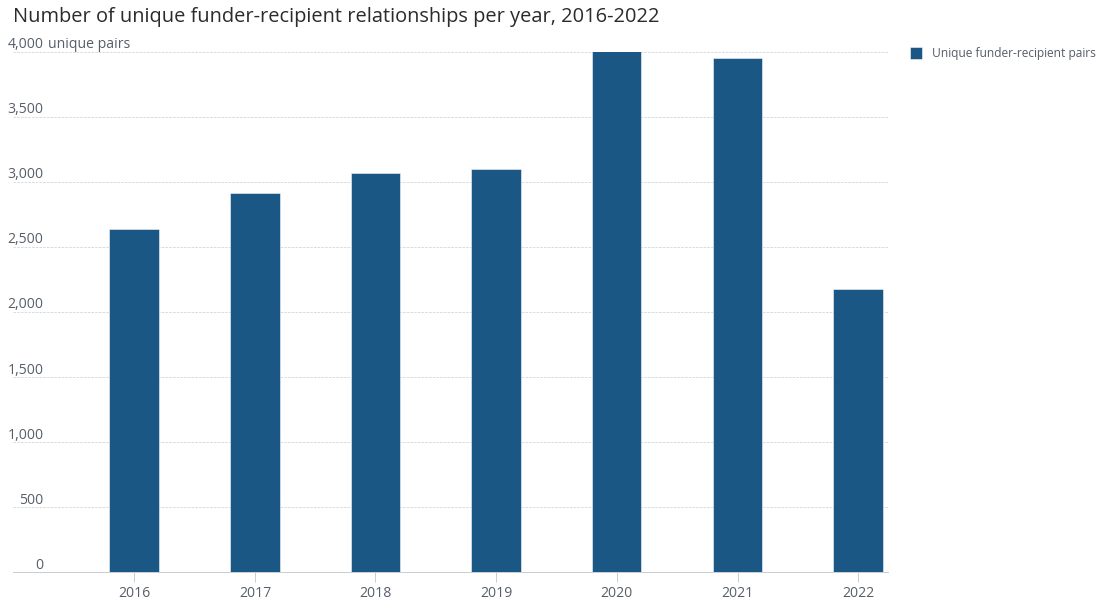

In [9]:
# Format figure
fig, ax = plt.subplots(figsize=(figure_size))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Define variables
x=uq_relationships['Date']
y=uq_relationships['Relationship Count']

bar_width=150

# Plot bars
# The thing that gets plotted last in this list gets plotted on the bottom
plt.bar(x, y, linewidth=0.5, width=bar_width, align="center", color=colors[0], label='Unique funder-recipient pairs')

# ax.xaxis_date()

# Define x-axis range
left = dt.date(2015,1,1)
right = dt.date(2022,4,1)

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,4000)

# Set title
title = "Number of unique funder-recipient relationships per year, 2016-2022"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)
    
# Format y-axis label
plt.ylabel("unique pairs", rotation=0,loc='top',labelpad=-123,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['{:,.0f}'.format(y) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-30) 

# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.25,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

plt.tight_layout(pad = 1.5)
# plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/uq_pairings_year_2016-22.png', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait')

### Bubble plot by number of relationships

In [10]:
bubs = df.groupby(['Date', 'Funder Category','Recipient Category','Funder Name','Recipient Name']).size().reset_index(name='Relationship Count')
bubs["Relationship Count"] = 1

bubs = bubs.groupby(['Funder Category','Recipient Category']).sum('Relationship Count').reset_index()


In [11]:
bubs.head()

,Funder Category,Recipient Category,Relationship Count
0,Country,Country,7459
1,Country,International,332
2,Country,Other,53
3,International,Country,7790
4,International,International,55


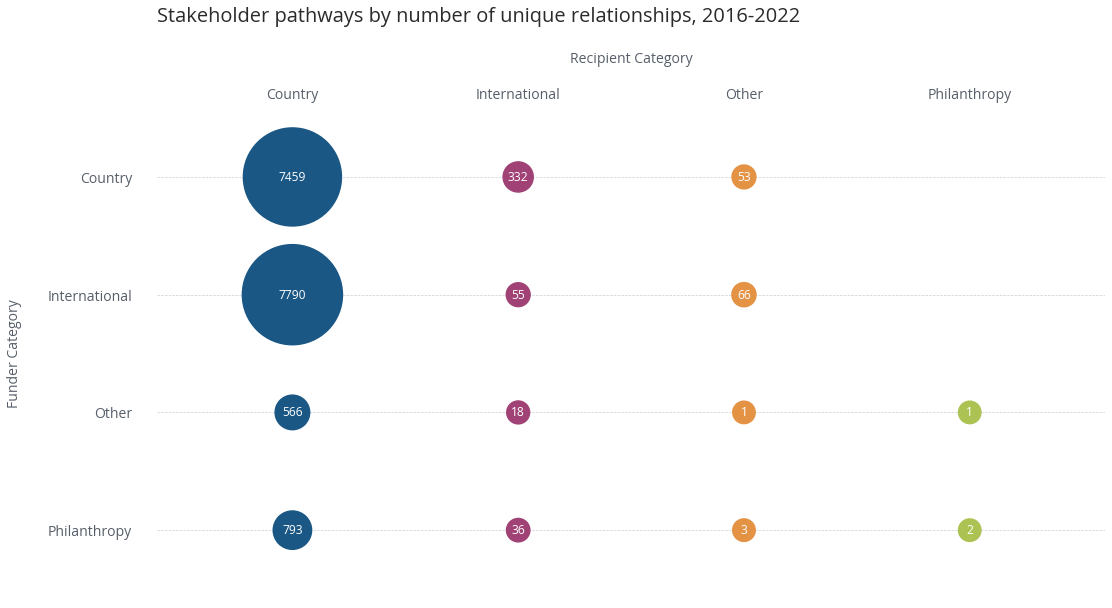

In [12]:
# Define a dictionary of colors for each Recipient Category
category_colors = {
    'Country': colors[0],
    'International': colors[8],
    'Other': colors[6],
    'Philanthropy': colors[4],
}

# Format figure
fig, ax = plt.subplots(figsize=(16, 9))
ax.spines.left.set_visible(False)
ax.spines.bottom.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Define variables
y = bubs['Funder Category']
x = bubs['Recipient Category'] 
s = bubs["Relationship Count"]

# Define the minimum and maximum size values
min_size = 500  # Adjust this value as needed
max_size = 10000

# Scale the size values to be between min_size and max_size
scaled_sizes = np.interp(s, (min(s), max(s)), (min_size, max_size))

# Plot bubbles with scaled sizes
plt.scatter(x, y, scaled_sizes, c=bubs['Recipient Category'].map(category_colors))

# Add text labels to the middle of each circle
for i, txt in enumerate(s):
    plt.annotate(txt, (x.iloc[i], y.iloc[i]), ha='center', va='center', fontsize=12,color='white')


# Set title
title = "Stakeholder pathways by number of unique relationships, 2016-2022"
plt.title(title, fontdict=titlefont, loc='left')

# Set tick labels and axis labels
ax.set_xlabel('Recipient Category', labelpad=25)
ax.xaxis.set_label_position('top')
ax.tick_params(axis='x', length=0, top=True, labeltop=True, bottom=False, labelbottom=False)
plt.margins(x=0.2, y=0.2)

ax.set_ylabel('Funder Category', labelpad=25)
ax.tick_params(axis='y', pad=25)

plt.setp(ax.get_yticklabels(), rotation=0)

# Reverse the y-axis
ax.invert_yaxis()

plt.tight_layout(pad=1.5)

# plt.show()
# plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/funder_pathway_sizes.png', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait')

## 4. What is the value of each funding pathway?
- Funding by category of funder/recipient
- Capacity and response
- 2016-2022

### Bubble plot by value of relationships

In [13]:
dots = df.groupby(['Funder Category','Recipient Category','Funder Name','Recipient Name']).sum("Total Disbursed to Recipient").reset_index()

dots = dots.groupby(['Funder Category','Recipient Category']).sum('Total Disbursed to Recipient').reset_index()

In [25]:
dots

,Funder Category,Recipient Category,Year,Total Disbursed to Recipient
0,Country,Country,42718711,1.243246e+11
1,Country,International,839893,3.177106e+10
2,Country,Other,670211,2.383422e+10
3,International,Country,41931531,1.244719e+11
4,International,International,193788,1.434857e+09
5,International,Other,813646,7.403717e+09
6,Other,Country,1903972,4.699723e+08
7,Other,International,38335,9.035466e+08
8,Other,Other,2020,2.000000e+06
9,Other,Philanthropy,2016,1.000000e+06


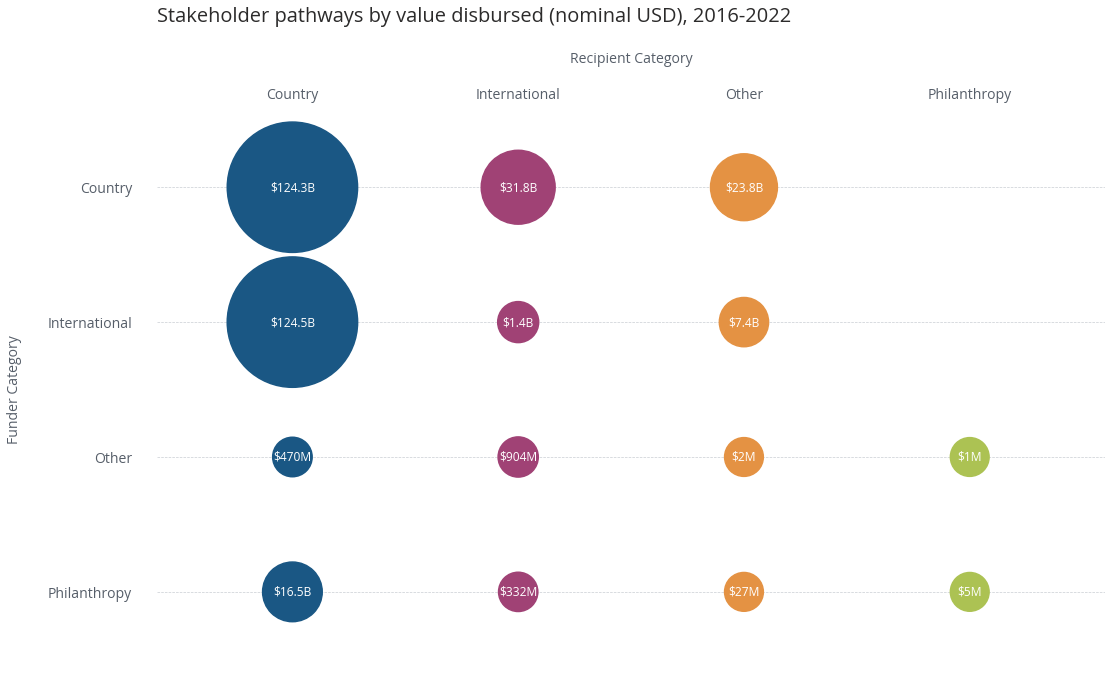

In [65]:
# Define a dictionary of colors for each Recipient Category
category_colors = {
    'Country': colors[0],
    'International': colors[8],
    'Other': colors[6],
    'Philanthropy': colors[4],
}

# Format figure
fig, ax = plt.subplots(figsize=(16, 10))
ax.spines.left.set_visible(False)
ax.spines.bottom.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Define variables
y = dots['Funder Category']
x = dots['Recipient Category'] 
s = dots["Total Disbursed to Recipient"]

# Define the minimum and maximum size values
min_size = 1500  # Adjust this value as needed
max_size = 17000

# Scale the size values to be between min_size and max_size
scaled_sizes = np.interp(s, (min(s), max(s)), (min_size, max_size))

# Plot bubbles with scaled sizes
plt.scatter(x, y, scaled_sizes, c=bubs['Recipient Category'].map(category_colors))

# Add text labels to the middle of each circle
for i, txt in enumerate(s):
    label_text = '${:,.1f}B'.format(txt / 1e9) if txt>1000000000 else '${:,.0f}M'.format(txt/1e6)

    plt.annotate(label_text, (x.iloc[i], y.iloc[i]), ha='center', va='center', fontsize=12,color='white')


# Set title
title = "Stakeholder pathways by value disbursed (nominal USD), 2016-2022"
plt.title(title, fontdict=titlefont, loc='left')

# Set tick labels and axis labels
ax.set_xlabel('Recipient Category', labelpad=25)
ax.xaxis.set_label_position('top')
ax.tick_params(axis='x', length=0, top=True, labeltop=True, bottom=False, labelbottom=False)
plt.margins(x=0.2, y=0.2)

ax.set_ylabel('Funder Category', labelpad=25)
ax.tick_params(axis='y', pad=25)

plt.setp(ax.get_yticklabels(), rotation=0)

# Reverse the y-axis
ax.invert_yaxis()

plt.tight_layout(pad=1.5)

# plt.show()
# plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/funder_pathway_values.png', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait')

### Stacked bar chart by value

In [71]:
area = df.groupby(['Year','Funder Category','Recipient Category','Funder Name','Recipient Name']).sum("Total Disbursed to Recipient").reset_index()

area = area.groupby(['Year','Funder Category','Recipient Category']).sum('Total Disbursed to Recipient').reset_index()

area['Pair'] = area["Funder Category"] + "-" + area["Recipient Category"]

# Clean data, converting year from numeric to datetime, and dropping the calculated columns
area['Year'] = pd.to_datetime(area['Year'], format='%Y').dt.year
area['Date'] = pd.to_datetime(area['Year'].astype(str) + '-01-01')

area.head()

,Year,Funder Category,Recipient Category,Total Disbursed to Recipient,Pair,Date
0,2016,Country,Country,1.206538e+10,Country-Country,2016-01-01
1,2016,Country,International,4.558013e+09,Country-International,2016-01-01
2,2016,Country,Other,2.973156e+09,Country-Other,2016-01-01
3,2016,International,Country,1.146279e+10,International-Country,2016-01-01
4,2016,International,International,2.956578e+08,International-International,2016-01-01


In [95]:
# Pivot the DataFrame with species as columns
pivot = area.pivot_table(index='Date', columns='Pair', values='Total Disbursed to Recipient', aggfunc = 'sum',fill_value=0)

# Flatten the DataFrame
pivot.reset_index(inplace=True)

pivot['Total'] = pivot.sum(axis=1)


pivot.head()

Pair,Date,Country-Country,Country-International,Country-Other,International-Country,International-International,International-Other,Other-Country,Other-International,Other-Other,Other-Philanthropy,Philanthropy-Country,Philanthropy-International,Philanthropy-Other,Philanthropy-Philanthropy,Total
0,2016-01-01,1.206538e+10,4.558013e+09,2.973156e+09,1.146279e+10,2.956578e+08,8.684761e+08,1.792004e+07,1.497605e+06,0,1000000,2.440292e+09,1.251979e+07,550000,4750000,3.470200e+10
1,2017-01-01,1.381529e+10,3.161879e+09,3.430575e+09,1.227319e+10,4.549311e+07,8.557408e+08,4.755813e+07,2.896446e+04,0,0,2.691420e+09,2.371681e+07,0,0,3.634489e+10
2,2018-01-01,1.459357e+10,3.147174e+09,3.779359e+09,1.125863e+10,6.062819e+07,9.731510e+08,6.177744e+07,0.000000e+00,0,0,2.773607e+09,4.544096e+07,0,0,3.669333e+10
3,2019-01-01,2.108456e+10,3.496643e+09,3.309579e+09,1.143997e+10,8.975013e+07,1.174963e+09,1.073082e+08,2.500000e+06,0,0,2.781266e+09,2.807681e+07,0,0,4.351462e+10
4,2020-01-01,2.575806e+10,8.702425e+09,3.320843e+09,3.223598e+10,5.859697e+08,1.541300e+09,1.527588e+08,2.828564e+08,2000000,0,3.274070e+09,1.697767e+08,12532550,0,7.603857e+10


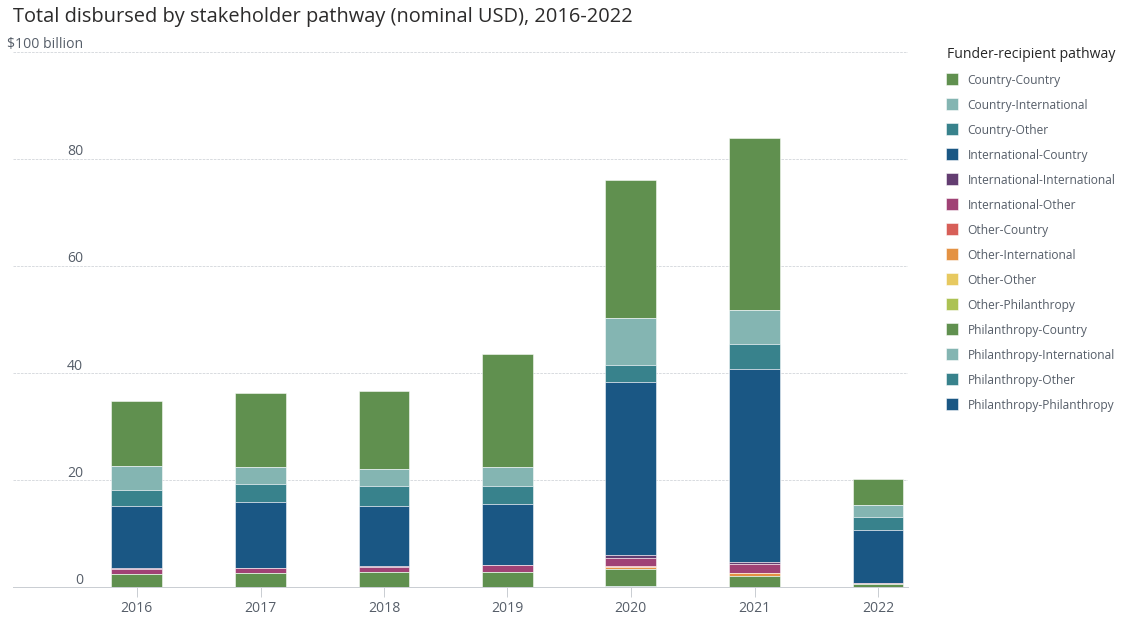

In [90]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Define variables
x=pivot['Date']
y14=pivot['Country-Country']
y13=pivot['Country-International']
y12=pivot['Country-Other']
y11=pivot['International-Country']
y10=pivot['International-International']
y9=pivot['International-Other']
y8=pivot['Other-Country']
y7= pivot['Other-International']
y6 = pivot['Other-Other']
y5 =pivot['Other-Philanthropy']
y4 =pivot['Philanthropy-Country']
y3 =pivot['Philanthropy-International']
y2 =pivot['Philanthropy-Other']
y1 =pivot['Philanthropy-Philanthropy']


# Plot bars
# The thing that gets plotted last in this list gets plotted on the bottom
bar_width = 150
plt.bar(x, y14, bottom=y1+y2+y3+y4+y5+y6+y7+y8+y9+y10+y11+y12+y13, linewidth=0.5, width=bar_width, align="center", color=colors[3], label='Country-Country')
plt.bar(x, y13, bottom=y1+y2+y3+y4+y5+y6+y7+y8+y9+y10+y11+y12, linewidth=0.5, width=bar_width, align="center", color=colors[2], label='Country-International')
plt.bar(x, y12, bottom=y1+y2+y3+y4+y5+y6+y7+y8+y9+y10+y11, linewidth=0.5, width=bar_width, align="center", color=colors[1], label='Country-Other')
plt.bar(x, y11, bottom=y1+y2+y3+y4+y5+y6+y7+y8+y9+y10, linewidth=0.5, width=bar_width, align="center", color=colors[0], label='International-Country')
plt.bar(x, y10, bottom=y1+y2+y3+y4+y5+y6+y7+y8+y9, linewidth=0.5, width=bar_width, align="center", color=colors[9], label='International-International')
plt.bar(x, y9, bottom=y1+y2+y3+y4+y5+y6+y7+y8, linewidth=0.5, width=bar_width, align="center", color=colors[8], label='International-Other')
plt.bar(x, y8, bottom=y1+y2+y3+y4+y5+y6+y7, linewidth=0.5, width=bar_width, align="center", color=colors[7], label='Other-Country')
plt.bar(x, y7, bottom=y1+y2+y3+y4+y5+y6, linewidth=0.5, width=bar_width, align="center", color=colors[6], label='Other-International')
plt.bar(x, y6, bottom=y1+y2+y3+y4+y5, linewidth=0.5, width=bar_width, align="center", color=colors[5], label='Other-Other')
plt.bar(x, y5, bottom=y1+y2+y3+y4, linewidth=0.5, width=bar_width, align="center", color=colors[4], label='Other-Philanthropy')
plt.bar(x, y4, bottom=y1+y2+y3, linewidth=0.5, width=bar_width, align="center", color=colors[3], label='Philanthropy-Country')
plt.bar(x, y3, bottom=y1+y2, linewidth=0.5, width=bar_width, align="center", color=colors[2], label='Philanthropy-International')
plt.bar(x, y2, bottom=y1, linewidth=0.5, width=bar_width, align="center", color=colors[1], label='Philanthropy-Other')
plt.bar(x, y1, bottom=0, linewidth=0.5, width=bar_width, align="center", color=colors[0], label='Philanthropy-Philanthropy')


# ax.xaxis_date()

# Define x-axis range
left = dt.date(2015,1,1)
right = dt.date(2022,4,1)

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,100e9)

# Set title
title = "Total disbursed by stakeholder pathway (nominal USD), 2016-2022"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['${:,.0f} billion'.format(y / 1e9) if i == 5 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-70) 


# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(title="Funder-recipient pathway",title_fontsize=14,handles=handles, labels=labels, bbox_to_anchor=(1.03,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)


plt.tight_layout()
# plt.show()
plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/disbursed_by_pathway_2016-22.png', dpi=1200, facecolor='w', 
            edgecolor='w', 
            orientation='portrait',bbox_inches='tight')

### Area chart

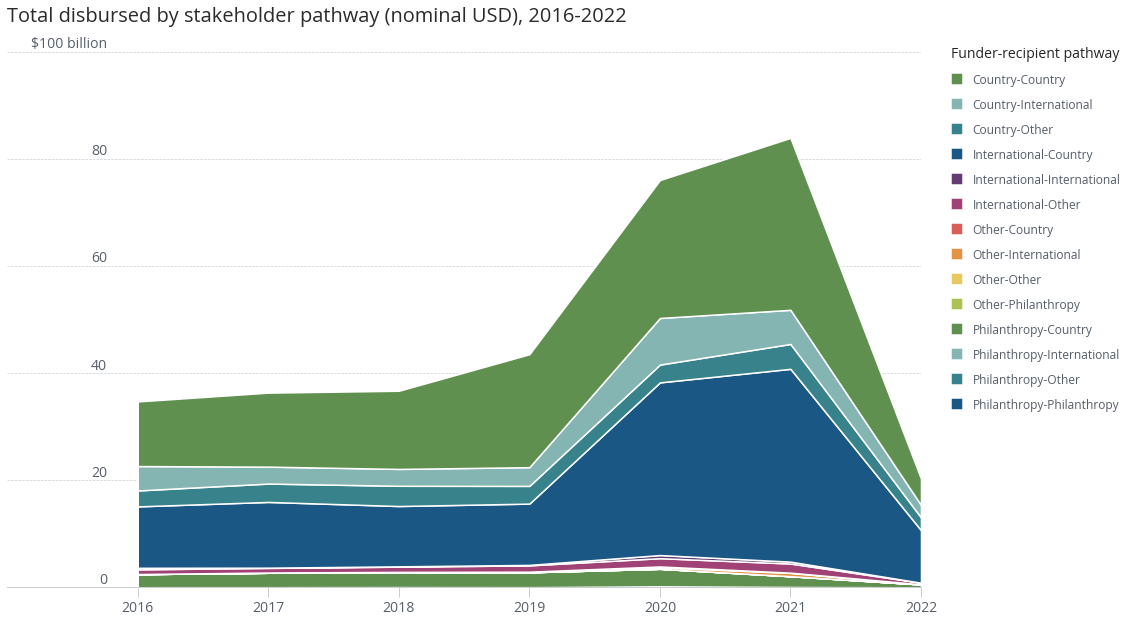

In [93]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Combine y-values into a list of lists
y_values = [y1, y2, y3, y4, y5, y6, y7, y8, y9, y10, y11, y12, y13, y14]
reversed_y_values = [y14, y13, y12, y11, y10, y9, y8, y7, y6, y5, y4, y3, y2, y1]


x = [2016, 2017, 2018, 2019, 2020, 2021, 2022]

labels = ['Country-Country','Country-International','Country-Other','International-Country','International-International','International-Other','Other-Country','Other-International','Other-Other','Other-Philanthropy','Philanthropy-Country','Philanthropy-International','Philanthropy-Other','Philanthropy-Philanthropy']

# Stackplot using x and y_values
plt.stackplot(x, y_values, colors = colors, labels=labels)

# Define x-axis range
left = 2015
right = 2022

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,100e9)

# Set title
title = "Total disbursed by stakeholder pathway (nominal USD), 2016-2022"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['${:,.0f} billion'.format(y / 1e9) if i == 5 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-100) 

# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
handles.reverse()
leg = ax.legend(title="Funder-recipient pathway", title_fontsize=14,handles=handles, labels=labels, bbox_to_anchor=(1.23,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

plt.tight_layout()
plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/disbursed_by_pathway_area_2016-22.png', dpi=1200, facecolor='w', 
            edgecolor='w', 
            orientation='portrait',bbox_inches='tight')

### Relative proportions

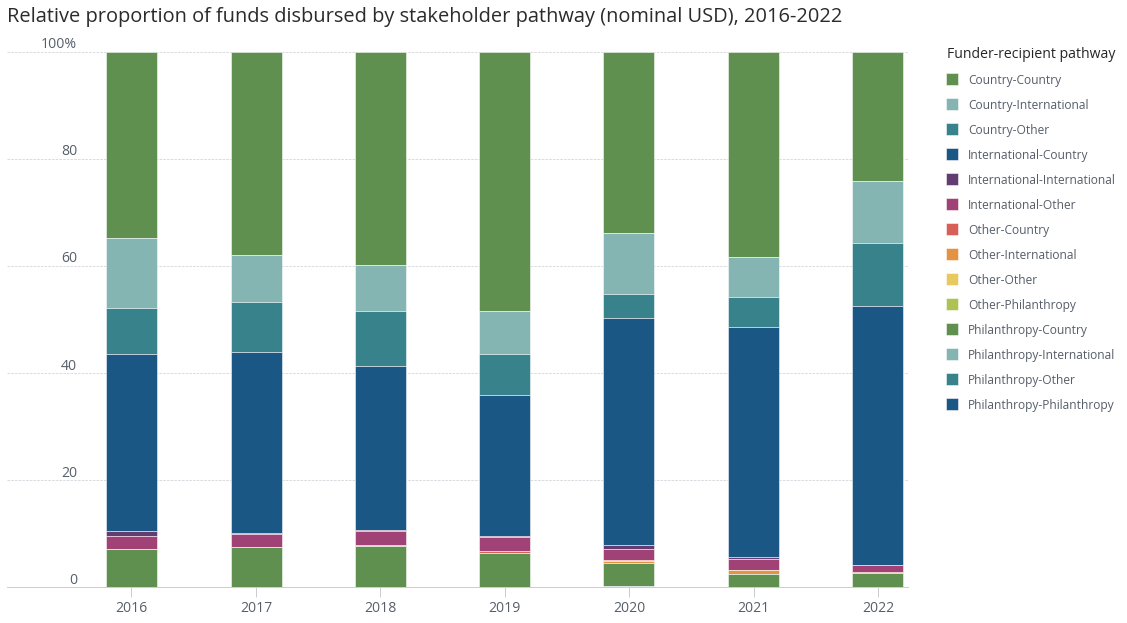

In [99]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Define variables
x=pivot['Date']
y14=(pivot['Country-Country']/pivot['Total'])*100
y13=(pivot['Country-International']/pivot['Total'])*100
y12=(pivot['Country-Other']/pivot['Total'])*100
y11=(pivot['International-Country']/pivot['Total'])*100
y10=(pivot['International-International']/pivot['Total'])*100
y9=(pivot['International-Other']/pivot['Total'])*100
y8=(pivot['Other-Country']/pivot['Total'])*100
y7= (pivot['Other-International']/pivot['Total'])*100
y6= (pivot['Other-Other']/pivot['Total'])*100
y5= (pivot['Other-Philanthropy']/pivot['Total'])*100
y4= (pivot['Philanthropy-Country']/pivot['Total'])*100
y3= (pivot['Philanthropy-International']/pivot['Total'])*100
y2= (pivot['Philanthropy-Other']/pivot['Total'])*100
y1= (pivot['Philanthropy-Philanthropy']/pivot['Total'])*100


# Plot bars
# The thing that gets plotted last in this list gets plotted on the bottom
bar_width = 150
plt.bar(x, y14, bottom=y1+y2+y3+y4+y5+y6+y7+y8+y9+y10+y11+y12+y13, linewidth=0.5, width=bar_width, align="center", color=colors[3], label='Country-Country')
plt.bar(x, y13, bottom=y1+y2+y3+y4+y5+y6+y7+y8+y9+y10+y11+y12, linewidth=0.5, width=bar_width, align="center", color=colors[2], label='Country-International')
plt.bar(x, y12, bottom=y1+y2+y3+y4+y5+y6+y7+y8+y9+y10+y11, linewidth=0.5, width=bar_width, align="center", color=colors[1], label='Country-Other')
plt.bar(x, y11, bottom=y1+y2+y3+y4+y5+y6+y7+y8+y9+y10, linewidth=0.5, width=bar_width, align="center", color=colors[0], label='International-Country')
plt.bar(x, y10, bottom=y1+y2+y3+y4+y5+y6+y7+y8+y9, linewidth=0.5, width=bar_width, align="center", color=colors[9], label='International-International')
plt.bar(x, y9, bottom=y1+y2+y3+y4+y5+y6+y7+y8, linewidth=0.5, width=bar_width, align="center", color=colors[8], label='International-Other')
plt.bar(x, y8, bottom=y1+y2+y3+y4+y5+y6+y7, linewidth=0.5, width=bar_width, align="center", color=colors[7], label='Other-Country')
plt.bar(x, y7, bottom=y1+y2+y3+y4+y5+y6, linewidth=0.5, width=bar_width, align="center", color=colors[6], label='Other-International')
plt.bar(x, y6, bottom=y1+y2+y3+y4+y5, linewidth=0.5, width=bar_width, align="center", color=colors[5], label='Other-Other')
plt.bar(x, y5, bottom=y1+y2+y3+y4, linewidth=0.5, width=bar_width, align="center", color=colors[4], label='Other-Philanthropy')
plt.bar(x, y4, bottom=y1+y2+y3, linewidth=0.5, width=bar_width, align="center", color=colors[3], label='Philanthropy-Country')
plt.bar(x, y3, bottom=y1+y2, linewidth=0.5, width=bar_width, align="center", color=colors[2], label='Philanthropy-International')
plt.bar(x, y2, bottom=y1, linewidth=0.5, width=bar_width, align="center", color=colors[1], label='Philanthropy-Other')
plt.bar(x, y1, bottom=0, linewidth=0.5, width=bar_width, align="center", color=colors[0], label='Philanthropy-Philanthropy')


# ax.xaxis_date()

# Define x-axis range
left = dt.date(2015,1,1)
right = dt.date(2022,4,1)

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,100)

# Set title
title = "Relative proportion of funds disbursed by stakeholder pathway (nominal USD), 2016-2022"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['{:,.0f}%'.format(y) if i == 5 else '{:,.0f}'.format(y) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-70) 


# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(title="Funder-recipient pathway",title_fontsize=14,handles=handles, labels=labels, bbox_to_anchor=(1.03,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)


plt.tight_layout()
# plt.show()
plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/disbursed_by_pathway_relative_2016-22.png', dpi=1200, facecolor='w', 
            edgecolor='w', 
            orientation='portrait',bbox_inches='tight')

## 5. How did funding fluctuate among the top 25 recipients? 
- Funding received for response and capacity
- 2016-2022

### Cleaning

In [132]:
# Get the top 10 recipients overall
top10 = df.groupby(['Recipient Name']).sum("Total Disbursed to Recipient").reset_index()
top10 = top10.sort_values(by="Total Disbursed to Recipient",ascending=False)
top10 = top10.head(11)
top10 = top10["Recipient Name"].unique().tolist()

# Filter df by those top 10 recipients, excluding not reported
top10_df = df[df["Recipient Name"].isin(top10)]
top10_df = top10_df.groupby(['Date','Recipient Name']).sum("Total Disbursed to Recipient").reset_index()
top10_df = top10_df[top10_df["Recipient Name"] != "Not reported"]

In [133]:
# Create the "other" funded entities
other = df[~df["Recipient Name"].isin(top10)]
other = other.groupby(['Date']).sum("Total Disbursed to Recipient").reset_index()
other["Recipient Name"] = "Other"

In [197]:
# Pivot the DataFrame
pivot = top10_df.pivot_table(index='Date', columns='Recipient Name', values='Total Disbursed to Recipient', aggfunc='sum', fill_value=0)
other_piv = other.pivot_table(index='Date', columns='Recipient Name', values='Total Disbursed to Recipient', aggfunc='sum', fill_value=0)

# Flatten the DataFrame
pivot.reset_index(inplace=True)
other_piv.reset_index(inplace=True)


Recipient Name,Date,Other
0,2016-01-01,1.700259e+10
1,2017-01-01,1.764080e+10
2,2018-01-01,1.803224e+10
3,2019-01-01,2.190002e+10
4,2020-01-01,4.864623e+10


### Stacked bar chart

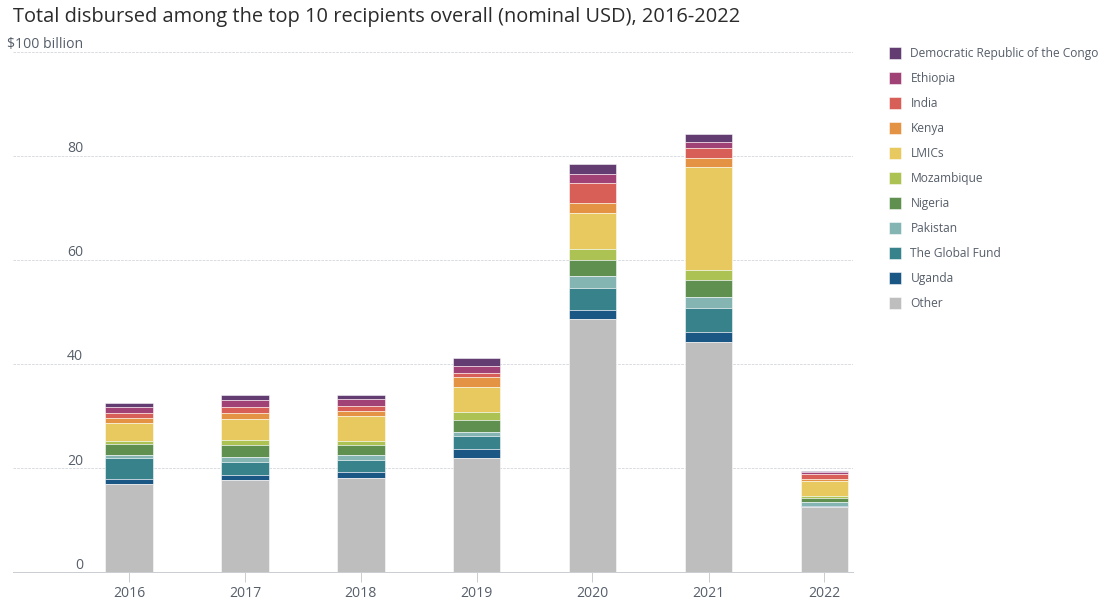

In [208]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Define variables
x= pivot['Date']
y11= pivot['Democratic Republic of the Congo']
y10= pivot['Ethiopia']
y9= pivot['India']
y8= pivot['Kenya']
y7= pivot['Low and middle-income countries (LMIC)']
y6= pivot['Mozambique']
y5= pivot['Nigeria']
y4= pivot['Pakistan']
y3= pivot['The Global Fund to Fight AIDS, Tuberculosis and Malaria']
y2= pivot['Uganda']
y1= other_piv['Other']


# Plot bars
# The thing that gets plotted last in this list gets plotted on the bottom
bar_width = 150
plt.bar(x, y11, bottom=y1+y2+y3+y4+y5+y6+y7+y8+y9+y10, linewidth=0.5, width=bar_width, align="center", color=colors[9], label='Democratic Republic of the Congo')
plt.bar(x, y10, bottom=y1+y2+y3+y4+y5+y6+y7+y8+y9, linewidth=0.5, width=bar_width, align="center", color=colors[8], label='Ethiopia')
plt.bar(x, y9, bottom=y1+y2+y3+y4+y5+y6+y7+y8, linewidth=0.5, width=bar_width, align="center", color=colors[7], label='India')
plt.bar(x, y8, bottom=y1+y2+y3+y4+y5+y6+y7, linewidth=0.5, width=bar_width, align="center", color=colors[6], label='Kenya')
plt.bar(x, y7, bottom=y1+y2+y3+y4+y5+y6, linewidth=0.5, width=bar_width, align="center", color=colors[5], label='LMICs')
plt.bar(x, y6, bottom=y1+y2+y3+y4+y5, linewidth=0.5, width=bar_width, align="center", color=colors[4], label='Mozambique')
plt.bar(x, y5, bottom=y1+y2+y3+y4, linewidth=0.5, width=bar_width, align="center", color=colors[3], label='Nigeria')
plt.bar(x, y4, bottom=y1+y2+y3, linewidth=0.5, width=bar_width, align="center", color=colors[2], label='Pakistan')
plt.bar(x, y3, bottom=y1+y2, linewidth=0.5, width=bar_width, align="center", color=colors[1], label='The Global Fund')
plt.bar(x, y2, bottom=y1, linewidth=0.5, width=bar_width, align="center", color=colors[0], label='Uganda')
plt.bar(x, y1, bottom=0, linewidth=0.5, width=bar_width, align="center", color=colors[10], label='Other')


# ax.xaxis_date()

# Define x-axis range
left = dt.date(2015,1,1)
right = dt.date(2022,4,1)

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,100e9)

# Set title
title = "Total disbursed among the top 10 recipients overall (nominal USD), 2016-2022"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['${:,.0f} billion'.format(y / 1e9) if i == 5 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-70) 


# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.03,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)


plt.tight_layout(pad=1.5)
# plt.show()
# plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/disbursed_to_top10_recipients_2016-22.png', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait',bbox_inches='tight')

### Area chart

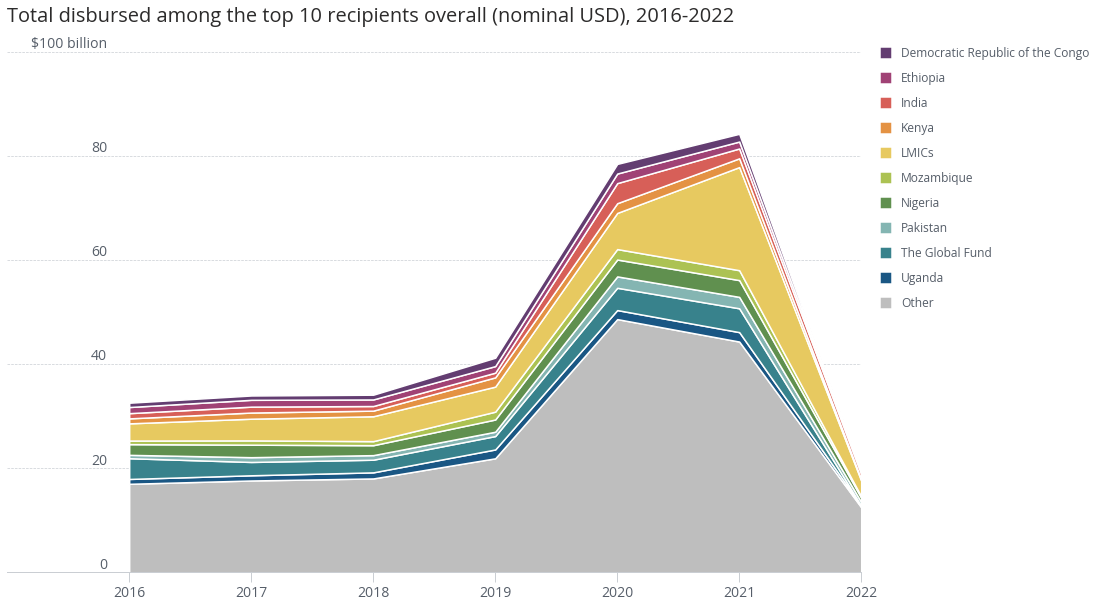

In [222]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Combine y-values into a list of lists
y_values = [y1, y2, y3, y4, y5, y6, y7, y8, y9, y10, y11]
reversed_y_values = [y11, y10, y9, y8, y7, y6, y5, y4, y3, y2, y1]


x = [2016, 2017, 2018, 2019, 2020, 2021, 2022]

labels = ['Democratic Republic of the Congo', 'Ethiopia', 'India', 'Kenya', 'LMICs', 'Mozambique', 'Nigeria', 'Pakistan', 'The Global Fund', 'Uganda', 'Other']
reverse_labels = ['Other', 'Uganda', 'The Global Fund', 'Pakistan', 'Nigeria', 'Mozambique', 'LMICs', 'Kenya', 'India', 'Ethiopia', 'Democratic Republic of the Congo']

#Stackplot using x and y_values
plt.stackplot(x, y_values, colors = ['#BEBEBE','#1A5784', '#38828C', '#84B5B2', '#60904F', '#ACC253', '#E7C960', '#E49243', '#D75F58', '#A04275', '#633D71'], labels=labels)

# Define x-axis range
left = 2015
right = 2022

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,100e9)

# Set title
title = "Total disbursed among the top 10 recipients overall (nominal USD), 2016-2022"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=0,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['${:,.0f} billion'.format(y / 1e9) if i == 5 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-100) 

# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
handles.reverse()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.28,1.03),labelcolor=chart[1],labelspacing=1,ncol=1)

plt.tight_layout(pad=1.5)
# plt.show()
plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/disbursed_to_top10_recipients_area_2016-22.png', dpi=1200, facecolor='w', 
            edgecolor='w', 
            orientation='portrait',bbox_inches='tight')

## 6. Which capacities are funded together?
- Funding received for capacity
- 2016-2019 and 2020-2022

### PCA Encoding and Cleaning

In [590]:
raw = pd.read_csv('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/analyses/Flows by funder, core capacity, recipient, and year/results/Flows with project IDs.csv')
raw = raw[raw["Funding type"] == "capacity"]
raw = raw[raw["Core capacity"] != "Unspecified"]
raw = raw[raw["Total Disbursed to Recipient"] >  100]

In [591]:
flows = raw.groupby(['Project ID','Total Disbursed to Recipient'])['Core capacity'].unique().reset_index()

In [592]:
flows = flows.sort_values(by="Total Disbursed to Recipient",ascending=False)

In [593]:
# Create dummy variables for each core capacity
core_capacity_dummies = flows['Core capacity'].str.join('|').str.get_dummies()

# Concatenate the dummy variables with the original DataFrame
df_encoded = pd.concat([flows, core_capacity_dummies], axis=1)

# Drop the original 'Core capacity' column
df_encoded = df_encoded.drop('Core capacity', axis=1)

In [594]:
from sklearn.decomposition import PCA

# Extract the one-hot encoded core capacities columns
core_capacity_columns = df_encoded.columns[2:]

# Apply PCA
pca = PCA()
pca_result = pca.fit_transform(df_encoded[core_capacity_columns])

# Add PCA results to the DataFrame
df_encoded['PCA_1'] = pca_result[:, 0]
df_encoded['PCA_2'] = pca_result[:, 1]

In [595]:
df_encoded = df_encoded.sort_values(by="Total Disbursed to Recipient",ascending=True)

### PCA Scatter

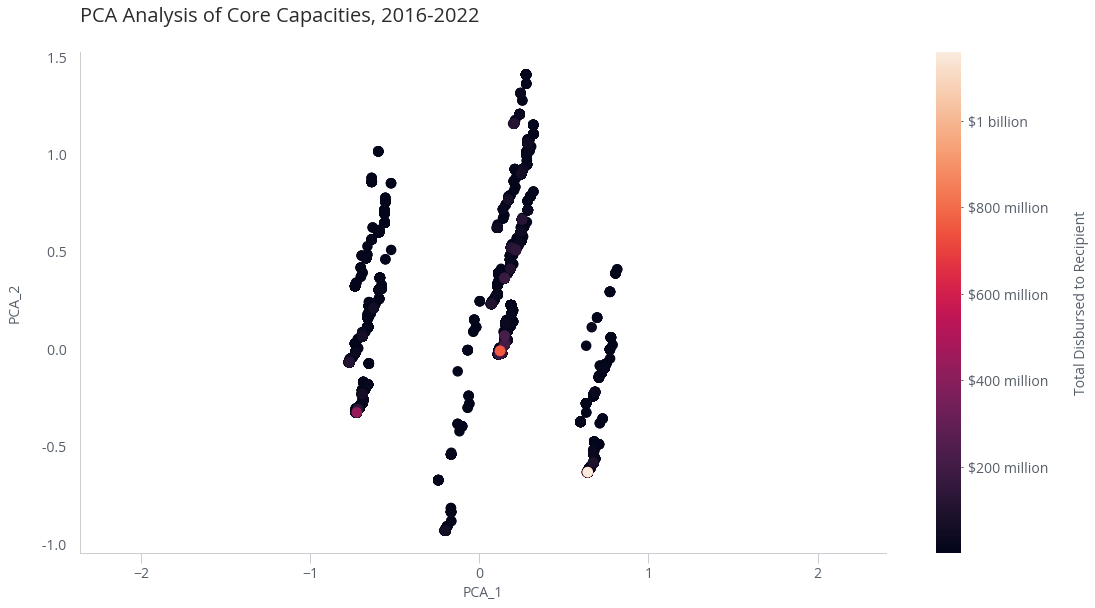

In [577]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(True)

# Format bottom axis
for axis in ['bottom','left']:
    ax.spines[axis].set_color(chart[2])
    

plt.scatter(df_encoded['PCA_1'], df_encoded['PCA_2'], c=df_encoded['Total Disbursed to Recipient'],alpha=1)
    
# Set title
title = "PCA Analysis of Core Capacities, 2016-2022"
plt.title(title, fontdict=titlefont, loc='left')

plt.xlabel('PCA_1')

  
# Format y-axis label
plt.ylabel("PCA_2", color=chart[1], labelpad=20)
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['{:.1f} '.format(y) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=10) 

# Customize color bar
cbar = plt.colorbar(drawedges=False)
cbar.set_label('Total Disbursed to Recipient', labelpad=25)
cbar.outline.set_visible(False)

# Set custom tick locations and labels
cbar_values = [0, 0.2e9, 0.4e9, 0.6e9, 0.8e9, 1e9]  # Custom tick locations
cbar_labels = ['${:.0f} million'.format(y/1e6) if y != 1e9 else '$1 billion' for y in cbar_values]  # Custom tick labels

cbar.set_ticks(cbar_values)
cbar.set_ticklabels(cbar_labels)

# Customize color bar appearance
cbar.ax.yaxis.set_tick_params(direction='out', length=2, width=1, pad=5, colors=chart[1], labelsize=14)

plt.tight_layout(pad=1.5)
# plt.show()
# plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/pca_analysis_core_capacities_2016-22.png', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait',bbox_inches='tight')

### Heat map

In [596]:
# Select the relevant columns (core capacities)
core_capacity_columns = df_encoded.columns[2:-2]  # Exclude the first and last two columns

# Calculate the co-occurrence matrix
cooccurrence_matrix = df_encoded[core_capacity_columns].T.dot(df_encoded[core_capacity_columns])

# Flatten the co-occurrence matrix into a DataFrame
cooccurrence_df = cooccurrence_matrix.unstack().reset_index()
cooccurrence_df.columns = ['Capacity_1', 'Capacity_2', 'Cooccurrence_Count']

# Get the top 5 pairs with the most frequent co-occurrence
top_cooccurrence_pairs = cooccurrence_df.sort_values(by='Cooccurrence_Count', ascending=False)

top_cooccurrence_pairs = top_cooccurrence_pairs[top_cooccurrence_pairs["Capacity_1"] != top_cooccurrence_pairs["Capacity_2"]]

# Drop every other row starting from the second row (index 1)
pairs = top_cooccurrence_pairs.drop(top_cooccurrence_pairs.index[1::2])

# Reset the index if needed
pairs.reset_index(drop=True, inplace=True)

pairs.head(20)

,Capacity_1,Capacity_2,Cooccurrence_Count
0,National Laboratory System,Real Time Surveillance,1620
1,Workforce Development,Reporting,1223
2,Real Time Surveillance,Antimicrobial Resistance (AMR),990
3,Reporting,Real Time Surveillance,988
4,National Laboratory System,Workforce Development,913
5,Real Time Surveillance,Workforce Development,720
6,Antimicrobial Resistance (AMR),National Laboratory System,689
7,Zoonotic Disease,Real Time Surveillance,607
8,Workforce Development,Zoonotic Disease,487
9,National Laboratory System,Reporting,469


In [599]:
columns = ['National Legislation, Policy, and Financing','IHR Coordination, Communicaton and Advocacy',
           'Antimicrobial Resistance (AMR)','Zoonotic Disease','Food Safety','Biosafety and Biosecurity',
           'Immunization','National Laboratory System','Real Time Surveillance','Reporting','Workforce Development',
           'Preparedness','Linking Public Health and Security Authorities',
           'Medical Countermeasures and Personnel Deployment','Risk Communication','Point of Entry (PoE)',
           'Chemical Events','Radiation Emergencies']
     

# Pivot the DataFrame to create a matrix for the heatmap
heatmap_data = pairs.pivot('Capacity_1', 'Capacity_2', 'Cooccurrence_Count').fillna(0)

heatmap_data = heatmap_data[columns]

# Reorder the rows to match the specified column order
heatmap_data = heatmap_data.reindex(columns, axis=0)


In [600]:
heatmap_data.head()

Capacity_2,"National Legislation, Policy, and Financing","IHR Coordination, Communicaton and Advocacy",Antimicrobial Resistance (AMR),Zoonotic Disease,Food Safety,Biosafety and Biosecurity,Immunization,National Laboratory System,Real Time Surveillance,Reporting,Workforce Development,Preparedness,Linking Public Health and Security Authorities,Medical Countermeasures and Personnel Deployment,Risk Communication,Point of Entry (PoE),Chemical Events,Radiation Emergencies
Capacity_1,,,,,,,,,,,,,,,,,,
"National Legislation, Policy, and Financing",0.0,0.0,0.0,0.0,0.0,0.0,163.0,0.0,0.0,197.0,367.0,0.0,0.0,184.0,0.0,19.0,0.0,1.0
"IHR Coordination, Communicaton and Advocacy",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Antimicrobial Resistance (AMR),76.0,0.0,0.0,418.0,29.0,7.0,64.0,689.0,0.0,139.0,120.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0
Zoonotic Disease,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,607.0,0.0,0.0,0.0,7.0,20.0,0.0,0.0,0.0,0.0
Food Safety,22.0,0.0,0.0,416.0,0.0,0.0,0.0,0.0,54.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,153.0


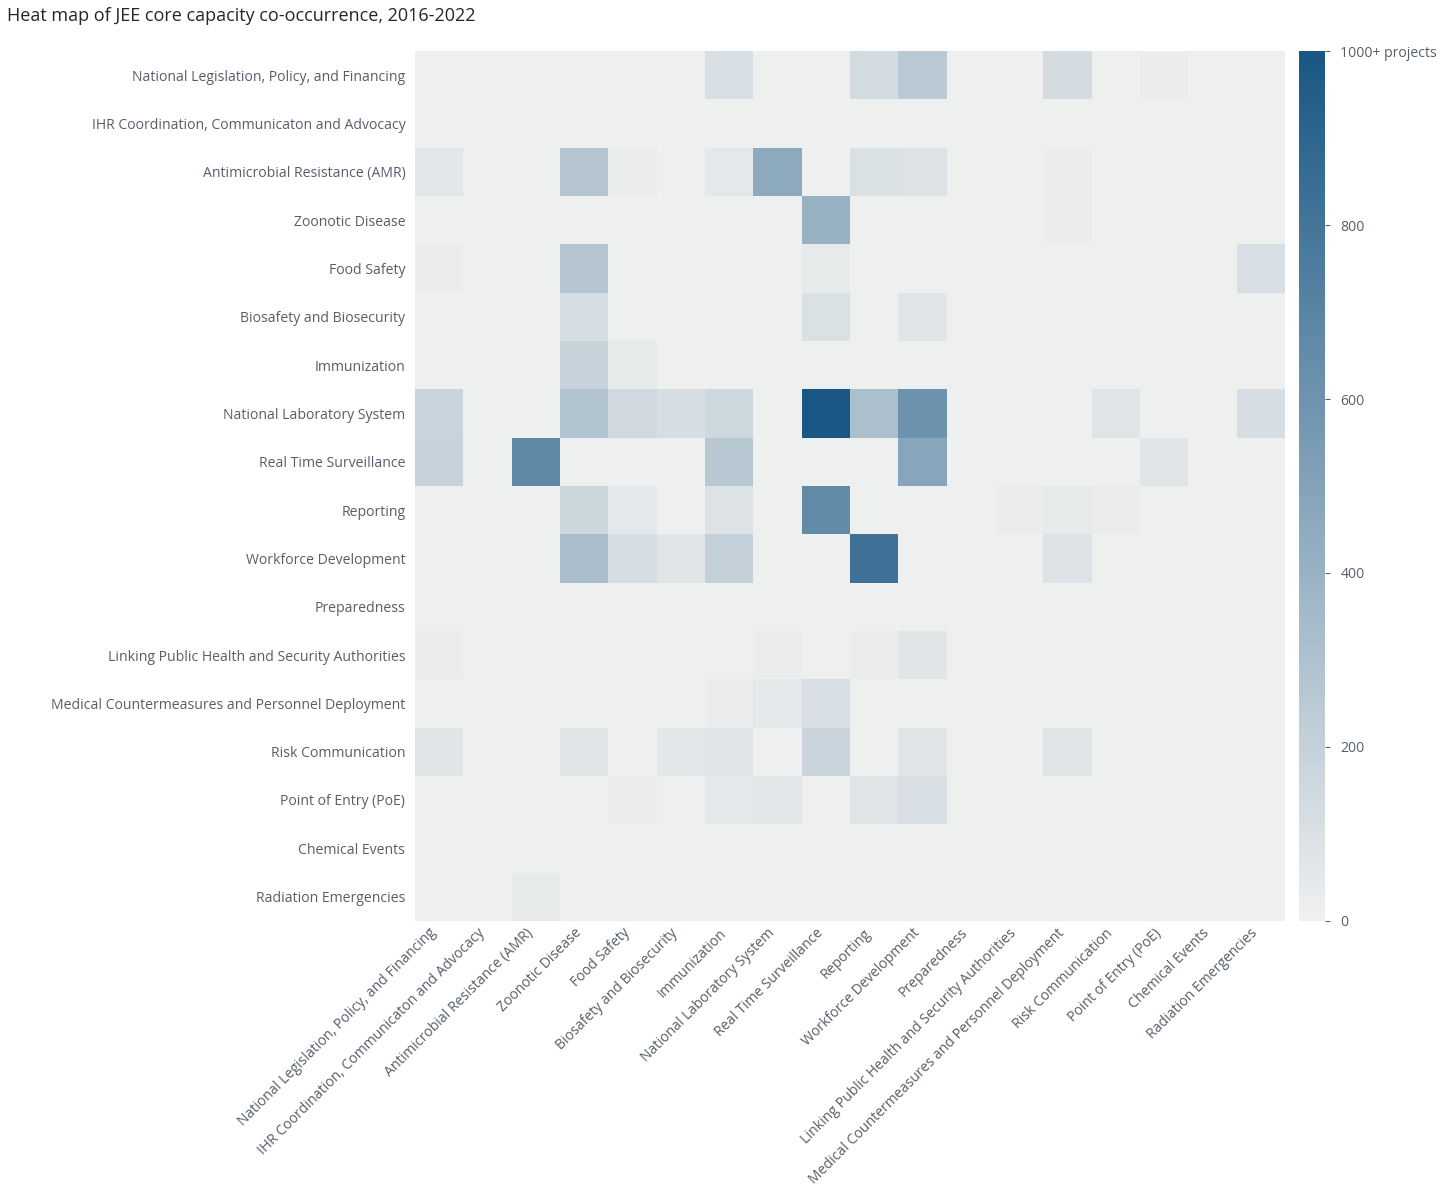

In [648]:
fig, ax = plt.subplots(figsize=(20,20))

im = ax.imshow(heatmap_data, cmap=cm, vmin=vmin, vmax=vmax)

# Create a colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
sm = plt.cm.ScalarMappable(cmap=cm,
                           norm=plt.Normalize())
sm._A = []
cbar = plt.colorbar(sm,cax=cax,drawedges=False,pad=20)
cbar.ax.yaxis.set_ticklabels(['0','200','400','600','800','1000+ projects'])
cbar.ax.yaxis.set_tick_params(direction='out',length=5,width=1,pad=10,colors=chart[1],labelsize=14)
cbar.outline.set_visible(False)

# Spines
ax.spines.bottom.set_visible(False)
ax.spines.left.set_visible(False)

# Set tick labels and axis labels
ax.set_xticks(range(len(columns)))
ax.set_xticklabels(columns,ha="right")
ax.tick_params(axis='x',pad=5,length=0,labelsize=14,width=30,rotation=45)
plt.setp(ax.get_xticklabels(), rotation=45)

ax.set_yticks(range(len(columns)))
ax.set_yticklabels(columns)
ax.tick_params(axis='y',pad=10,width=30,labelsize=14)
ax.tick_params(top=False, bottom=True, labeltop=False, labelbottom=True)



# Set title and show the plot
ax.set_title("Heat map of JEE core capacity co-occurrence, 2016-2022",fontsize=18,x=-.2)
plt.tight_layout(pad=1.5)
# plt.show()

# plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/heatmap_core_capacities_2016-22.png', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait',bbox_inches='tight')

## How was funding allocated during PHEICs?

### Cleaning

In [701]:
raw = pd.read_csv('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/analyses/Flows by PHEIC/results/Flows by PHEIC__latest.csv')
raw.head()

,Funder Name,Recipient Name,PHEIC Name,Total Disbursed to Recipient
0,Global Alliance for Vaccines and Immunisation ...,Low and middle-income countries (LMIC),2019-2022 COVID-19 Pandemic,7.154838e+09
1,United States of America,Low and middle-income countries (LMIC),2019-2022 COVID-19 Pandemic,4.042188e+09
2,United States Agency for International Develop...,Low and middle-income countries (LMIC),2019-2022 COVID-19 Pandemic,4.000000e+09
3,Asian Development Bank,Philippines,2019-2022 COVID-19 Pandemic,2.237407e+09
4,Asian Development Bank,Indonesia,2019-2022 COVID-19 Pandemic,2.040552e+09


### Bar chart

In [702]:
df = raw.groupby(['PHEIC Name']).sum("Total Disbursed to Recipient").reset_index()
df.head()

,PHEIC Name,Total Disbursed to Recipient
0,2009-2010 H1N1,2.325176e+07
1,2014-2016 Ebola in West Africa,3.535142e+09
2,2014-2022 Poliovirus,8.920072e+09
3,2015-2016 Zika Virus,2.337080e+08
4,2018-2020 Ebola in DRC,1.532695e+09


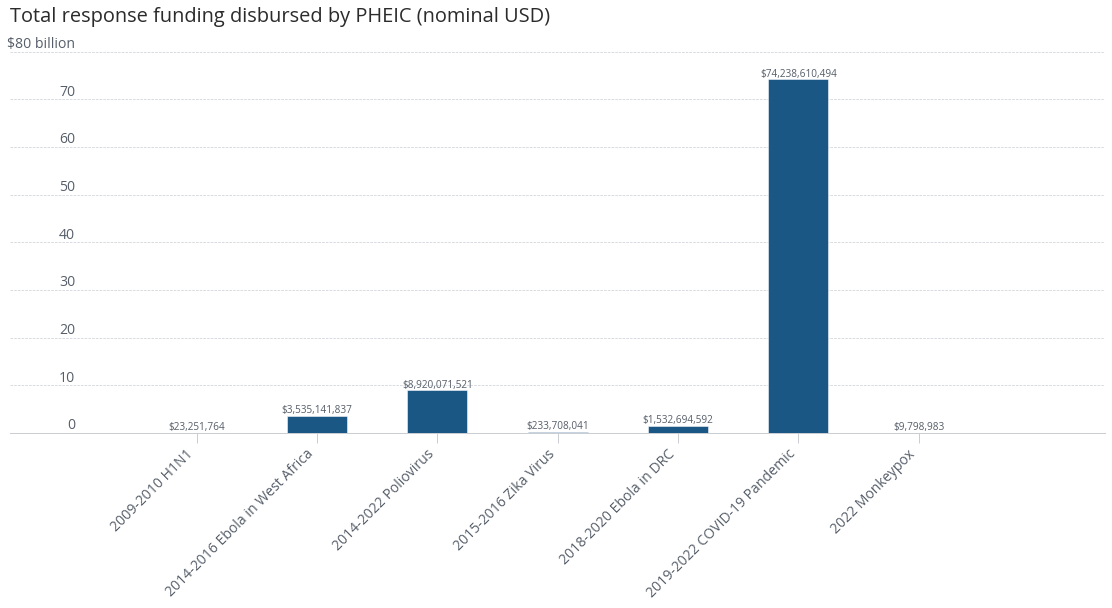

In [708]:
# Format figure
fig, ax = plt.subplots(figsize=(16,9))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Define variables
x=df['PHEIC Name']
y=df['Total Disbursed to Recipient']

bar_width=0.5

# Plot bars
# The thing that gets plotted last in this list gets plotted on the bottom
bars = plt.bar(x, y, linewidth=0.5, width=bar_width, align="center", color=colors[0])

# Annotate y-values on top of each bar
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             '${:,.0f}'.format(bar.get_height()),
             ha='center', va='bottom', fontsize=10, color=chart[1])

# Changes y-axis range
plt.gca().set_ybound(0,80000000000)

# Set title
title = "Total response funding disbursed by PHEIC (nominal USD)"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")
plt.xticks(rotation=45, ha="right")
    
# Format y-axis label
plt.ylabel("", rotation=0,loc='top',labelpad=-123,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")


tick_values = plt.gca().get_yticks()
tick_labels = ['${:,.0f} billion'.format(y/1e9) if i ==8 else '{:,.0f}'.format(y/1e9) for i, y in enumerate(tick_values)]

plt.gca().set_yticklabels(tick_labels)

plt.gca().yaxis.set_tick_params(pad=-65) 

plt.tight_layout(pad = 1.5)
# plt.show()
# plt.savefig('/Users/haileyrobertson/Documents/GitHub/ghs-tracking-analysis/figures/disbursed_by_pheic.png', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait')